# HW1.2: Word Tokenizer##

In this exercise, you are going to build a set of deep learning models on a (sort of) real world task using pyTorch. PyTorch is a deep learning framwork developed by facebook to provide an easier way to use standard layers and networks.

To complete this exercise, you will need to build deep learning models for word tokenization in Thai (แบ่งเว้นวรรคภาษาไทย) using NECTEC's BEST corpus. You will build one model for each of the following type:
- Fully Connected (Feedforward) Neural Network
- One-Dimentional Convolution Neural Network (1D-CNN)
- Recurrent Neural Network with Gated Recurrent Unit (GRU)

and one more model of your choice to achieve the highest score possible.

We provide the code for data cleaning and some starter code for PyTorch in this notebook but feel free to modify those parts to suit your needs. Feel free to use additional libraries (e.g. scikit-learn) as long as you have a model for each type mentioned above.

**Don't forget to change hardware accelerator to GPU in Google Colab.**


In [52]:
#pip install wandb torchsummaryX

In [53]:
#pip install torchinfo

In [1]:
# Run setup code
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gdown
import torch
from sklearn.metrics import accuracy_score
from tqdm import tqdm

%matplotlib inline

# To guarantee reproducible results
torch.manual_seed(5420)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(5420)

## Setup

1. Register [Wandb account](https://wandb.ai/login?signup=true) (and confirm your email)

2. `wandb login` and copy paste the API key when prompt

In [55]:
#wandb login

In [2]:
import wandb

In [3]:
#Check GPU is available
torch.cuda.device_count()

1

In [58]:
# from google.colab import drive
# drive.mount('/content/drive')

In [59]:
# tar -xvf corpora.tar.gz

In [60]:
# Prepare data
# You don't need to run the following code as we already did it for you to give everyone the same dataset
# import cattern.data_utils
# cattern.data_utils.generate_best_dataset(os.getcwd()+'/data', create_val=True)

For simplicity, we are going to build a word tokenization model which is a binary classification model trying to predict whether a character is the begining of the word or not (if it is, then there is a space in front of it) and without using any knowledge about type of character (vowel, number, English character etc.).

For example,

'แมวดำน่ารักมาก' -> 'แมว ดำ น่า รัก มาก'

will have these true labels:

[(แ,1), (ม,0), (ว,0) (ด,1), ( ำ,0), (น,1), (-่,0), (า,0), (ร,1), (-ั,0), (ก,0), (ม,1), (า,0), (ก,0)]

In this task, we will use only main character you are trying to predict  and the characters that surround it (the context) as features. However, you can imagine that a more complex model will try to include more knowledge about each character into the model. You can do that too if you feel like it.

In [5]:
# Create a character map
CHARS = [
  '\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+',
  ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8',
  '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E',
  'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R',
  'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_',
  'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
  'n', 'o', 'other', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y',
  'z', '}', '~', 'ก', 'ข', 'ฃ', 'ค', 'ฅ', 'ฆ', 'ง', 'จ', 'ฉ', 'ช',
  'ซ', 'ฌ', 'ญ', 'ฎ', 'ฏ', 'ฐ', 'ฑ', 'ฒ', 'ณ', 'ด', 'ต', 'ถ', 'ท',
  'ธ', 'น', 'บ', 'ป', 'ผ', 'ฝ', 'พ', 'ฟ', 'ภ', 'ม', 'ย', 'ร', 'ฤ',
  'ล', 'ว', 'ศ', 'ษ', 'ส', 'ห', 'ฬ', 'อ', 'ฮ', 'ฯ', 'ะ', 'ั', 'า',
  'ำ', 'ิ', 'ี', 'ึ', 'ื', 'ุ', 'ู', 'ฺ', 'เ', 'แ', 'โ', 'ใ', 'ไ',
  'ๅ', 'ๆ', '็', '่', '้', '๊', '๋', '์', 'ํ', '๐', '๑', '๒', '๓',
  '๔', '๕', '๖', '๗', '๘', '๙', '‘', '’', '\ufeff'
]
CHARS_MAP = {v: k for k, v in enumerate(CHARS)}

In [6]:
len(CHARS_MAP)

178

In [7]:
def create_n_gram_df(df, n_pad):
  """
  Given an input dataframe, create a feature dataframe of shifted characters
  Input:
  df: timeseries of size (N)
  n_pad: the number of context. For a given character at position [idx],
    character at position [idx-n_pad/2 : idx+n_pad/2] will be used
    as features for that character.

  Output:
  dataframe of size (N * n_pad) which each row contains the character,
    n_pad_2 characters to the left, and n_pad_2 characters to the right
    of that character.
  """
  n_pad_2 = int((n_pad - 1)/2)
  for i in range(n_pad_2):
      df['char-{}'.format(i+1)] = df['char'].shift(i + 1)
      df['char{}'.format(i+1)] = df['char'].shift(-i - 1)
  return df[n_pad_2: -n_pad_2]

In [8]:
# สมมติว่า df มีข้อมูล "hello world" และ n_pad = 3

import pandas as pd
# สร้างตัวอย่าง DataFrame ที่มีคอลัมน์ 'char'
data = {'char': list("hello world")}
df = pd.DataFrame(data)

# ใช้ context window ขนาด 3
result = create_n_gram_df(df, 3)
print(result)

  char char-1 char1
1    e      h     l
2    l      e     l
3    l      l     o
4    o      l      
5           o     w
6    w            o
7    o      w     r
8    r      o     l
9    l      r     d


In [10]:
def prepare_feature(best_processed_path, option='train'):
  """
  Transform the path to a directory containing processed files
  into a feature matrix and output array
  Input:
  best_processed_path: str, path to a processed version of the BEST dataset (เส้นทางไปยังโฟลเดอร์ที่เก็บไฟล์ CSV ของชุดข้อมูล BEST )
  option: str, 'train' or 'test' (กำหนดว่าจะใช้ข้อมูล train หรือ test)
  """
  # we use padding equals 21 here to consider 10 characters to the left
  # and 10 characters to the right as features for the character in the middle
  n_pad = 21
  n_pad_2 = int((n_pad - 1)/2)
  pad = [{'char': ' ', 'target': True}]
  df_pad = pd.DataFrame(pad * n_pad_2)

  df = []
  # article types in BEST corpus
  article_types = ['article', 'encyclopedia', 'news', 'novel']
  for article_type in article_types:
      df.append(pd.read_csv(os.path.join(best_processed_path, option, 'df_best_{}_{}.csv'.format(article_type, option))))

  df = pd.concat(df) #รวมข้อมูลทั้งหมดให้เป็น DataFrame เดียว
  # pad with empty string feature
  df = pd.concat((df_pad, df, df_pad))

  # map characters to numbers, use 'other' if not in the predefined character set.
  df['char'] = df['char'].map(lambda x: CHARS_MAP.get(x, 80)) #หากตัวอักษรไม่อยู่ใน CHARS_MAP จะถูกแทนที่ด้วยค่า 80 (สัญลักษณ์ "อื่นๆ") # CHARS_MAP['other'] = 80

  # Use nearby characters as features
  df_with_context = create_n_gram_df(df, n_pad=n_pad)


  # set pattern to left|right|center
  char_row = ['char' + str(i + 1) for i in range(n_pad_2)] + \
             ['char-' + str(i + 1) for i in range(n_pad_2)] + ['char']

  # convert pandas dataframe to numpy array to feed to the model
  x_char = df_with_context[char_row].to_numpy()
  y = df_with_context['target'].astype(int).to_numpy()

  return x_char, y

Before running the following commands, we must inform you that our data is quite large and loading the whole dataset at once will **use a lot of memory (~6 GB after processing and up to ~12GB while processing)**. We expect you to be running this on Google Cloud or Google Colab so that you will not run into this problem. But, if, for any reason, you have to run this on your PC or machine with not enough memory, you might need to write a data generator to process a few entries at a time then feed it to the model while training.


In [11]:
# Path to the preprocessed data
best_processed_path = 'corpora.tar.gz/BEST'

In [12]:
# Load preprocessed BEST corpus
x_train_char, y_train = prepare_feature(best_processed_path, option='train')
x_val_char, y_val = prepare_feature(best_processed_path, option='val')
x_test_char, y_test = prepare_feature(best_processed_path, option='test')

# As a sanity check, we print out the size of the training, val, and test data.
print('Training data shape: ', x_train_char.shape)
print('Training data labels shape: ', y_train.shape)
print('Validation data shape: ', x_val_char.shape)
print('Validation data labels shape: ', y_val.shape)
print('Test data shape: ', x_test_char.shape)
print('Test data labels shape: ', y_test.shape)

Training data shape:  (16461637, 21)
Training data labels shape:  (16461637,)
Validation data shape:  (2035694, 21)
Validation data labels shape:  (2035694,)
Test data shape:  (2271932, 21)
Test data labels shape:  (2271932,)


**Example of data preprocessing and labeling**

Setting window site = 21 (left character length = 10, Center letter = 1, right character length = 10)

**For the frist sample from trainig data**

- **ค**ณะตุลาการร (**'ค'** is the first Character so **it is labeled to 1**)

--> _ _ _ _ _ _ _ _ _ _ **ค** ณะตุลาการร

-- > \[Embedding Vector\] --> | 1 1 1 1 1 1 1 1 1 1 | **97.** | 112. 140. 114. 148. 130. 142.  94. 142. 128. 128. |

--> \[Rearange of embeding vector pattern to \] --> | 112. 140. 114. 148. 130. 142. 94. 142. 128. 128. | 1 1 1 1 1 1 1 1 1 1 | **97.** |

as shown in the output cell below.

**For the next sample from trainig data (Slide the window one step)**

- ค**ณ**ะตุลาการรั (**'ณ'** is not the first Character so **it is labeled to 0**)

--> _ _ _ _ _ _ _ _ _ ค **ณ** ะตุลาการรั

-- > \[Embedding Vector\] --> | 1 1 1 1 1 1 1 1 1 97. | **112.** | 140. 114. 148. 130. 142.  94. 142. 128. 128. 141.|

--> \[Rearange of embeding vector pattern to \] -->  | 140. 114. 148. 130. 142.  94. 142. 128. 128. 141. | 97. 1 1 1 1 1 1 1 1 1 | **112.**|

as shown in the output cell below.

**For the next sample from trainig data (Slide the window one step)**

- คณ **ะ** ตุลาการรัฐ (**ะ** is not the first Character so **it is labeled to 0**)

--> _ _ _ _ _ _ _ _ คณ **ะ** ตุลาการรัฐ

-- > \[Embedding Vector\] --> | 1 1 1 1 1 1 1 1 97. 112.| **140.** | 114. 148. 130. 142.  94. 142. 128. 128. 141. 109.|

--> \[Rearange of embeding vector pattern to \] -->  | 114. 148. 130. 142.  94. 142. 128. 128. 141. 109.| 112. 97. 1 1 1 1 1 1 1 1 | **140.** |

as shown in the output cell below.




In [13]:
# Print some entry from the data to make sure it is the same as what you think.
print('First 3 features: ', x_train_char[:3])
print('First 30 class labels', y_train[:30])

First 3 features:  [[112. 140. 114. 148. 130. 142.  94. 142. 128. 128.   1.   1.   1.   1.
    1.   1.   1.   1.   1.   1.  97.]
 [140. 114. 148. 130. 142.  94. 142. 128. 128. 141.  97.   1.   1.   1.
    1.   1.   1.   1.   1.   1. 112.]
 [114. 148. 130. 142.  94. 142. 128. 128. 141. 109. 112.  97.   1.   1.
    1.   1.   1.   1.   1.   1. 140.]]
First 30 class labels [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0]


In [14]:
#print char of feature 1
char = np.array(CHARS)

#A function for displaying our features in text
def print_features(tfeature,label,index):
    feature = np.array(tfeature[index],dtype=int).reshape(21,1)
    #Convert to string
    char_list = char[feature]
    left = ''.join(reversed(char_list[10:20].reshape(10))).replace(" ", "")
    center = ''.join(char_list[20])
    right =  ''.join(char_list[0:10].reshape(10)).replace(" ", "")
    word = ''.join([left,' ',center,' ',right])
    print(center + ': ' + word + "\tpred = "+str(label[index]))

for ind in range(0,30):
    print_features(x_train_char,y_train,ind)

ค:  ค ณะตุลาการร	pred = 1
ณ: ค ณ ะตุลาการรั	pred = 0
ะ: คณ ะ ตุลาการรัฐ	pred = 0
ต: คณะ ต ุลาการรัฐธ	pred = 0
ุ: คณะต ุ ลาการรัฐธร	pred = 0
ล: คณะตุ ล าการรัฐธรร	pred = 0
า: คณะตุล า การรัฐธรรม	pred = 0
ก: คณะตุลา ก ารรัฐธรรมน	pred = 0
า: คณะตุลาก า รรัฐธรรมนู	pred = 0
ร: คณะตุลากา ร รัฐธรรมนูญ	pred = 0
ร: คณะตุลาการ ร ัฐธรรมนูญก	pred = 0
ั: ณะตุลาการร ั ฐธรรมนูญกั	pred = 0
ฐ: ะตุลาการรั ฐ ธรรมนูญกับ	pred = 0
ธ: ตุลาการรัฐ ธ รรมนูญกับค	pred = 0
ร: ุลาการรัฐธ ร รมนูญกับคว	pred = 0
ร: ลาการรัฐธร ร มนูญกับควา	pred = 0
ม: าการรัฐธรร ม นูญกับความ	pred = 0
น: การรัฐธรรม น ูญกับความเ	pred = 0
ู: ารรัฐธรรมน ู ญกับความเป	pred = 0
ญ: รรัฐธรรมนู ญ กับความเป็	pred = 0
ก: รัฐธรรมนูญ ก ับความเป็น	pred = 1
ั: ัฐธรรมนูญก ั บความเป็นอ	pred = 0
บ: ฐธรรมนูญกั บ ความเป็นอง	pred = 0
ค: ธรรมนูญกับ ค วามเป็นองค	pred = 1
ว: รรมนูญกับค ว ามเป็นองค์	pred = 0
า: รมนูญกับคว า มเป็นองค์ก	pred = 0
ม: มนูญกับควา ม เป็นองค์กร	pred = 0
เ: นูญกับความ เ ป็นองค์กรต	pred = 1
ป: ูญกับความเ ป ็นองค์กรตุ	pred = 0
็: ญกับความ

Now, you are going to define the model to be used as your classifier. If you are using Pytorch, please follow the guideline we provide below.  You can find more about PyTorch model structure here [documentation](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html).

In short, you need to inherit the class `torch.nn.Module` and override the constructor and the method `forward` as shown below:
```python
Class Model(torch.nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    #init layer
  def forward(self, x):
    #forward pass the model
```

Also, beware that complex model requires more time to train and your dataset is already quite large. We tested it with a simple 1-hidden-layered feedforward nueral network and it used ~5 mins to train 1 epoch.

# Three-Layer Feedforward Neural Networks

Below, we provide you the code for creating a 3-layer fully connected neural network in PyTorch. This will also serve as the baseline for your other models. Run the code below while making sure you understand what you are doing. Then, report the results.

In [15]:
import torch.nn.functional as F  # ฟังก์ชันช่วยเช่น ReLU, Sigmoid (Helper functions like ReLU, Sigmoid)
from torchinfo import summary  # ใช้ดูโครงสร้างของโมเดล (Used for viewing the model structure)
# from torchsummaryX import summary  # อีกทางเลือกสำหรับการดูโครงสร้างโมเดล (Another option for model summary)

class SimpleFeedforwardNN(torch.nn.Module):  # สืบทอดจาก torch.nn.Module (Inherits from torch.nn.Module)

  # การสร้างโมเดล (define model layers)
  def __init__(self):
    super(SimpleFeedforwardNN, self).__init__() #ใช้เรียกฟังก์ชันของคลาสหลัก เพื่อให้สามารถใช้คุณสมบัติของ torch.nn.Module ได้

    # การกำหนดโครงสร้างของ Neural Network
    # สร้างชั้นของ Fully Connected Layers (Define Fully Connected Layers) #โมเดลนี้มี 3 ชั้นซ่อน (Hidden Layers) และ 1 ชั้นเอาต์พุต (Output Layer)
    self.mlp1 = torch.nn.Linear(21, 100)  # อินพุตมี 21 นิวรอน ส่งไปยัง 100 นิวรอน (Input: 21 neurons -> 100 neurons)
    self.mlp2 = torch.nn.Linear(100, 100) # hidden ที่มี 100 นิวรอน (Hidden layer: 100 neurons)
    self.mlp3 = torch.nn.Linear(100, 100) # hidden อีกชั้น (Another hidden layer: 100 neurons)
    self.cls_head = torch.nn.Linear(100, 1)  # เอาต์พุตเป็น 1 นิวรอน (Output layer: 1 neuron)

  # การกำหนดการไหลของข้อมูลในโมเดล
  def forward(self, x):
    x = F.relu(self.mlp1(x))  # ใช้ ReLU Activation (Apply ReLU activation)
    x = F.relu(self.mlp2(x))
    x = F.relu(self.mlp3(x))
    x = self.cls_head(x)  # ไม่มี Activation Function ที่ output layer (No activation function at the output layer)
    out = torch.sigmoid(x)  # ใช้ Sigmoid เพื่อให้ค่าผลลัพธ์อยู่ในช่วง [0,1] (Use Sigmoid to get values in the range [0,1])
    return out

model = SimpleFeedforwardNN() #Initialize model
model.cuda() #specify the location that it is in the GPU

summary(model, input_size=(1, 21))
# summary(model,  torch.zeros((1, 21), dtype = torch.float).cuda() ) #summarize the model

Layer (type:depth-idx)                   Output Shape              Param #
SimpleFeedforwardNN                      [1, 1]                    --
├─Linear: 1-1                            [1, 100]                  2,200
├─Linear: 1-2                            [1, 100]                  10,100
├─Linear: 1-3                            [1, 100]                  10,100
├─Linear: 1-4                            [1, 1]                    101
Total params: 22,501
Trainable params: 22,501
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.02
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.09
Estimated Total Size (MB): 0.09

### Test whether the model is working as intended by passing dummy input.

In [16]:
#สร้างอาร์เรย์ของ NumPy ขนาด (64, 21) ที่มีค่าเป็น ศูนย์ทั้งหมด
# 64 → หมายถึงจำนวนตัวอย่าง (Batch size)
# 21 → หมายถึงจำนวนฟีเจอร์ (ตรงกับจำนวนอินพุตของโมเดล)
# torch.tensor(..., dtype=torch.float) → แปลงอาร์เรย์ NumPy เป็น Tensor ที่ใช้กับ PyTorch

test_X = torch.tensor(np.zeros((64, 21)), dtype = torch.float).cuda()
print(model(test_X).shape)
#64 → เนื่องจากอินพุตมี 64 ตัวอย่าง (Batch size = 64) โมเดลจึงให้ผลลัพธ์สำหรับ 64 ตัวอย่าง
#1 → เพราะชั้นสุดท้ายของโมเดล (self.cls_head) มี 1 นิวรอน จึงได้ค่าเอาต์พุตเพียงค่าเดียวต่อ 1 ตัวอย่าง

torch.Size([64, 1])


A tensor is very similar to numpy, and many numpy functions has a tensor equivalent.

In [17]:
# สร้าง tensor จากช่วงตัวเลข 0 ถึง 5 (Create a tensor with a range of values from 0 to 5)
example_tensor = torch.arange(6)
print(example_tensor, example_tensor.shape)  # แสดงขนาดของ tensor (Print the shape of the tensor)

# การบวกและการคูณ (Addition and multiplication)
print(example_tensor * 2 + 1)  # คูณ tensor ด้วย 2 แล้วบวก 1 (Multiply the tensor by 2 and add 1)

# การปรับขนาด tensor (Resize the tensor)
example_tensor = example_tensor.view((2, 3))  # เปลี่ยนรูป tensor เป็นขนาด 2x3 (Reshape the tensor to 2x3)
print(example_tensor)  # แสดงผลลัพธ์หลังจากการเปลี่ยนรูป (Print the reshaped tensor)

# สร้างตัวอย่าง tensor สองตัว (Create two example tensors)
example_tensor1 = torch.tensor([[[[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]]]], dtype = torch.float)
example_tensor2 = torch.ones_like(example_tensor1)  # สร้าง tensor ที่มีค่าเป็น 1 โดยมีขนาดเท่ากับ example_tensor1 (Create a tensor with all ones, same size as example_tensor1)
print(example_tensor1.shape, example_tensor2.shape)  # แสดงขนาดของ tensor ทั้งสอง (Print the shapes of both tensors)

# แสดงค่า tensor ทั้งสอง (Print both tensors)
print(example_tensor1)
print(example_tensor2)

# การคูณ matrix (Matrix multiplication)
print(example_tensor1.matmul(example_tensor2))  # คูณ tensor สองตัว (Matrix multiplication of the two tensors)


tensor([0, 1, 2, 3, 4, 5]) torch.Size([6])
tensor([ 1,  3,  5,  7,  9, 11])
tensor([[0, 1, 2],
        [3, 4, 5]])
torch.Size([1, 1, 4, 4]) torch.Size([1, 1, 4, 4])
tensor([[[[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])
tensor([[[[1., 1., 1., 1.],
          [1., 1., 1., 1.],
          [1., 1., 1., 1.],
          [1., 1., 1., 1.]]]])
tensor([[[[10., 10., 10., 10.],
          [26., 26., 26., 26.],
          [42., 42., 42., 42.],
          [58., 58., 58., 58.]]]])


To debug, you can always just try passing variables through individual layers by yourself.

In [18]:
#โค้ดนี้เป็นการ ทดสอบและดีบัก (Debug) ชั้น Linear Layer ใน PyTorch โดยใช้ตัวอย่างข้อมูล x_train_char เพื่อดูว่าข้อมูลไหลผ่านเลเยอร์อย่างไรและผลลัพธ์มีขนาดเท่าใด


mlp_test = torch.nn.Linear(21, 3).cuda() # สร้าง Fully Connected Layer (Linear Layer) ที่รับอินพุต 21 ฟีเจอร์ และให้เอาต์พุต 3 ฟีเจอร์
print(x_train_char[:4])
print(x_train_char[:4].shape)

test_input = torch.tensor(x_train_char[:4], dtype = torch.float).cuda() #แปลงข้อมูล x_train_char เป็น PyTorch Tensor
print(mlp_test(test_input).shape)
print(mlp_test(test_input)) #นำข้อมูล (4, 21) ผ่าน Linear Layer ค่าที่ได้จะเป็น Tensor ขนาด (4, 3)

[[112. 140. 114. 148. 130. 142.  94. 142. 128. 128.   1.   1.   1.   1.
    1.   1.   1.   1.   1.   1.  97.]
 [140. 114. 148. 130. 142.  94. 142. 128. 128. 141.  97.   1.   1.   1.
    1.   1.   1.   1.   1.   1. 112.]
 [114. 148. 130. 142.  94. 142. 128. 128. 141. 109. 112.  97.   1.   1.
    1.   1.   1.   1.   1.   1. 140.]
 [148. 130. 142.  94. 142. 128. 128. 141. 109. 117. 140. 112.  97.   1.
    1.   1.   1.   1.   1.   1. 114.]]
(4, 21)
torch.Size([4, 3])
tensor([[-10.7609,  35.0017, -75.6997],
        [-27.3164,  26.4542, -69.2510],
        [ -9.0613,  42.3437, -91.1748],
        [-21.3748,  35.3703, -57.5476]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


### Typical PyTorch training loop

Before the training loop begins, a data loader respondsible for generating data in a trainable format has to be created first. In Pytorch, `torch.utils.data.Dataloader` is a readily available class that are commonly used for data preparation. The dataloader takes the object `torch.utils.data.Dataset` as an input. An example of a data loader for this task is shown below. You can read more about the class `Dataset` here https://pytorch.org/tutorials/beginner/basics/data_tutorial.html.

### Converting the data into trainable format

In order to train the model using the PyTorch frame, the data has to be converted into `Tensor type`. In the cell below, we convert the data into `cuda.FloatTensor` type. You can read more about `Tensor` data type here : https://pytorch.org/docs/stable/tensors.html.

In [19]:
# สร้างคลาส Dataset ที่สืบทอดมาจาก torch.utils.data.Dataset ซึ่งเป็นคลาสพื้นฐานสำหรับการทำงานกับข้อมูลใน PyTorch
# คลาสนี้จะใช้สำหรับการโหลดข้อมูลและเตรียมข้อมูลให้พร้อมใช้ในระหว่างการฝึกโมเดล (Dataset class that inherits from torch.utils.data.Dataset)
class Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'

    def __init__(self, X, Y, dtype = 'float'):
        'Initialization'  # ฟังก์ชัน constructor ที่ใช้เริ่มต้นค่าและเตรียมข้อมูล (Initialization function)
        # กำหนดค่า X และ Y ซึ่งคือข้อมูลและป้ายกำกับ (Set input data (X) and labels (Y))
        self.X = X
        self.Y = Y.reshape(-1, 1)  # เปลี่ยนรูป Y ให้เป็นเวกเตอร์คอลัมน์ (Reshape Y into a column vector)

        # ตรวจสอบประเภทของ dtype และแปลงข้อมูล X และ Y ให้เป็น tensor ใน PyTorch และย้ายข้อมูลไปที่ GPU (Check dtype and convert data to tensor)
        if(dtype == 'float'):  # ถ้า dtype คือ 'float' ให้แปลง X เป็น float tensor (If dtype is 'float', convert X to float tensor)
            self.X = torch.tensor(self.X, dtype = torch.float).cuda()  # ใช้ dtype float และย้ายไป GPU (Use float dtype and move to GPU)
        elif(dtype == 'long'):  # ถ้า dtype คือ 'long' ให้แปลง X เป็น long tensor (If dtype is 'long', convert X to long tensor)
            self.X = torch.tensor(self.X, dtype = torch.long).cuda()  # ใช้ dtype long และย้ายไป GPU (Use long dtype and move to GPU)

        self.Y = torch.tensor(self.Y, dtype = torch.float).cuda()  # แปลง Y เป็น float tensor และย้ายไป GPU (Convert Y to float tensor and move to GPU)

    def __len__(self): #ฟังก์ชัน __len__ (คืนค่าจำนวนตัวอย่างทั้งหมด)
        'Denotes the total number of samples'
        return len(self.X)  # คืนค่าจำนวนตัวอย่าง (Return the number of samples)

    def __getitem__(self, index): #ฟังก์ชัน __getitem__ (ดึงข้อมูลตัวอย่างจาก Dataset ตาม index ที่กำหนด)
        'Generates one sample of data'

        # เลือกตัวอย่างตาม index ที่ระบุ (Select sample by the given index)
        x = self.X[index]  # เลือก X ตาม index (Select X based on index)
        y = self.Y[index, :]  # เลือก Y ตาม index (Select Y based on index)

        return x, y  # คืนค่าตัวอย่าง x และ y (Return the sample x and y)


In the block below, we initialized the hyperparameters used for the training process. Normally, the optimizer, objective function, and training schedule is initialized here.

In [20]:
x_train_char, y_train

(array([[112., 140., 114., ...,   1.,   1.,  97.],
        [140., 114., 148., ...,   1.,   1., 112.],
        [114., 148., 130., ...,   1.,   1., 140.],
        ...,
        [137., 100.,   1., ..., 152., 100., 151.],
        [100.,   1.,   1., ..., 126., 152., 137.],
        [  1.,   1.,   1., ..., 159., 126., 100.]], shape=(16461637, 21)),
 array([1, 0, 0, ..., 1, 0, 0], shape=(16461637,)))

In [21]:
Dataset(x_train_char, y_train, dtype = 'float')

In [22]:
from torch.utils.data import DataLoader #ใช้สำหรับโหลดข้อมูลเป็น batch
import torch.optim as optim #ใช้สำหรับกำหนด Optimizer ในการปรับค่าถ่วงน้ำหนักของโมเดล

#hyperparameter initialization
NUM_EPOCHS = 3 # จำนวนรอบการฝึก (epochs)
model_checkpoint_path_feedforward_nn = './model_weight_feedforward_nn.h5' # ไฟล์สำหรับบันทึกน้ำหนักของโมเดล
criterion = torch.nn.BCELoss(reduction = 'none') # ฟังก์ชัน Loss สำหรับ Binary Classification
BATCHS_SIZE = 512  # ขนาดของ Batch
optimizer = optim.Adam(model.parameters(), lr=5e-4) # ใช้ Adam optimizer ในการอัปเดตค่าถ่วงน้ำหนัก
eps = 1e-10 # ค่าคงที่ขนาดเล็กเพื่อป้องกันการหารด้วยศูนย์

#การตั้งค่าการติดตามผลด้วย Weights & Biases (wandb)
config = {
    'architecture': 'simpleff', #ชื่อโปรเจกต์เป็น "simpleff"
    'epochs': 3
}
wandb.init(
    project='simpleff',
    config=config,
)
wandb.config = {
    'architecture': 'simpleff',
    'epochs': 3
}


train_loader = DataLoader( Dataset(x_train_char, y_train, dtype = 'float'), batch_size = BATCHS_SIZE)
val_loader = DataLoader( Dataset(x_val_char, y_val, dtype = 'float'), batch_size = BATCHS_SIZE)
test_loader = DataLoader( Dataset(x_test_char, y_test, dtype = 'float'), batch_size = BATCHS_SIZE)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: memekhos001 (memekhos001-kmutt) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


### Starting the training loop


In [21]:
# ติดตามการฝึกโมเดลด้วย Weights & Biases (Track the model training with Weights & Biases)
wandb.watch(model, log='all')


idx = 0 # ใช้นับจำนวนรอบการอัปเดตพารามิเตอร์ (iterations)
best_val_acc = 0 #ใช้เก็บค่าความแม่นยำสูงสุดที่ได้จาก validation

# เริ่มต้นรอบการฝึก (Training loop for NUM_EPOCHS)
for n_epoch in range(NUM_EPOCHS):
    print("EPOCH :", n_epoch + 1)  # แสดงหมายเลขรอบฝึก (Print current epoch number)

    model.train() # set โมเดลให้อยู่ในโหมดการฝึก (Set the model to training mode)
    print("TRAINING LOOP")

    # วนลูปฝึกแต่ละ batch จาก train_loader (Iterate through training batches)
    for X_train, Y_train in tqdm(train_loader): # วนลูปแต่ละ batch ของข้อมูลฝึก
        optimizer.zero_grad()  # เคลียร์ gradient ของรอบที่แล้ว (Clear gradients from previous step)
        Y_pred = model(X_train)  # คำนวณค่าทำนาย (Make predictions)
        loss = criterion(Y_pred, Y_train).mean()  # คำนวณ loss (Calculate the loss)
        loss.backward()  # คำนวณ gradients (Backpropagation)
        optimizer.step()  # อัปเดตพารามิเตอร์โมเดล (Update model parameters)

        # บันทึกข้อมูลการฝึกใน WandB (Log training loss and iteration count to WandB)
        wandb.log({
            'train_loss': loss,  # ค่าความสูญเสียในการฝึก (Training loss)
            'n_iter' : idx  # จำนวนการวนรอบ (Iteration count)
        })

        idx += 1  # เพิ่มค่าจำนวน Iteration

    # เริ่ม validation loop (Validation loop: ใช้ accuracy เป็นเมตริกหลัก) (Validation loop for simplicity using accuracy as the primary metric)
    model.eval()  # set โมเดลให้อยู่ในโหมด validation (Set the model to evaluation mode)
    with torch.no_grad():  # ปิดการคำนวณ gradient สำหรับ validation (Disable gradient computation)
        print("VALIDATION LOOP")

        # ตัวแปรเก็บข้อมูลสำหรับการ validation (Initialize variables for validation data)
        val_loss = []
        val_pred = []
        val_true = []

        for X_val, Y_val in tqdm(val_loader): # วนลูปแต่ละ batch ของ validation
            Y_pred = model(X_val)  # คำนวณค่าทำนายจาก validation (Make predictions on validation data)
            loss = criterion(Y_pred, Y_val)  # คำนวณค่า loss (Calculate the loss)

            # เก็บข้อมูล loss และค่าทำนายใน validation (Store loss and predictions)
            val_loss.append(loss)
            val_pred.append(Y_pred)
            val_true.append(Y_val)

        # คำนวณค่า loss และความแม่นยำเฉลี่ยในการ validation (Calculate average validation loss and accuracy)
        avg_val_loss = torch.concatenate(val_loss, axis = 0).mean().item()  # ค่า loss เฉลี่ยในการ validation (Average validation loss)
        val_pred = torch.concatenate(val_pred, axis = 0).cpu().detach().numpy()  # ค่าทำนายในการ validation (Validation predictions) #Tensor → NumPy Array
        val_true = torch.concatenate(val_true, axis = 0).cpu().detach().numpy()  # ค่าจริงในการ validation (True values for validation) #Tensor → NumPy Array

        # แปลงค่าทำนายเป็นคลาส (0 หรือ 1) (Convert predictions to class labels)
        prob_to_class = lambda p: 1 if p[0]>=0.5 else 0
        val_pred = np.apply_along_axis(prob_to_class,1,val_pred)

        # คำนวณความแม่นยำในการ validation (Calculate accuracy)
        val_acc = accuracy_score(val_true, val_pred)

        print("val loss:", avg_val_loss)  # แสดงค่า loss ของ validation (Print validation loss)
        print("val accuracy:", val_acc)  # แสดงความแม่นยำของ validation (Print validation accuracy)

        # ถ้าความแม่นยำในการ validation ดีที่สุด ให้บันทึกโมเดล (Save the model if validation accuracy improves)
        if(best_val_acc < val_acc):
            best_val_acc = val_acc
            torch.save(model.state_dict(), model_checkpoint_path_feedforward_nn)  # บันทึกพารามิเตอร์ของโมเดล (Save model parameters)

        # บันทึกข้อมูลการ validation ใน WandB (Log validation accuracy and loss to WandB)
        wandb.log({
            'val_accuracy' : val_acc,  # ความแม่นยำในการ validation (Validation accuracy)
            'val_loss': avg_val_loss,  # ค่า loss ของ validation (Validation loss)
        })


EPOCH : 1
TRAINING LOOP


100%|██████████| 32152/32152 [02:04<00:00, 258.13it/s]


VALIDATION LOOP


100%|██████████| 3976/3976 [00:11<00:00, 358.77it/s]


val loss: 0.31511759757995605
val accuracy: 0.8668851998384826
EPOCH : 2
TRAINING LOOP


100%|██████████| 32152/32152 [02:22<00:00, 226.07it/s]


VALIDATION LOOP


100%|██████████| 3976/3976 [00:13<00:00, 302.30it/s]


val loss: 0.2918456196784973
val accuracy: 0.8803494041835365
EPOCH : 3
TRAINING LOOP


100%|██████████| 32152/32152 [02:24<00:00, 222.04it/s]


VALIDATION LOOP


100%|██████████| 3976/3976 [00:16<00:00, 247.65it/s]


val loss: 0.2665041983127594
val accuracy: 0.8934284818838195


### Evaluate the model performance on the test set

In [23]:
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

################################################################################
# A function to evaluate your model. This function must take test dataloader   #
# and the input model to return f-score, precision, and recall of the model.   #
################################################################################
def evaluate(test_loader, model):
  """
  Evaluate model on the splitted 10 percent testing set.
  """
  model.eval()
  with torch.no_grad():
    test_loss = []
    test_pred = []
    test_true = []
    for X_test, Y_test in tqdm(test_loader):
      Y_pred = model(X_test)
      loss = criterion(Y_pred, Y_test)
      test_loss.append(loss)
      test_pred.append(Y_pred)
      test_true.append(Y_test)

    avg_test_loss = torch.concatenate(test_loss, axis = 0).mean().item()
    test_pred = torch.concatenate(test_pred, axis = 0).cpu().detach().numpy()
    test_true = torch.concatenate(test_true, axis = 0).cpu().detach().numpy()

    prob_to_class = lambda p: 1 if p[0]>=0.5 else 0
    test_pred = np.apply_along_axis(prob_to_class,1,test_pred)

    acc = accuracy_score(test_true, test_pred)
    f1score = f1_score(test_true, test_pred)
    precision = precision_score(test_true, test_pred)
    recall = recall_score(test_true, test_pred)
    
   # Compute confusion matrix
    conf_matrix = confusion_matrix(test_true, test_pred)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

  return acc, f1score, precision, recall, avg_test_loss

C:\Users\Aitthikit\AppData\Local\Temp\ipykernel_34256\1105749467.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_checkpoint_path_f

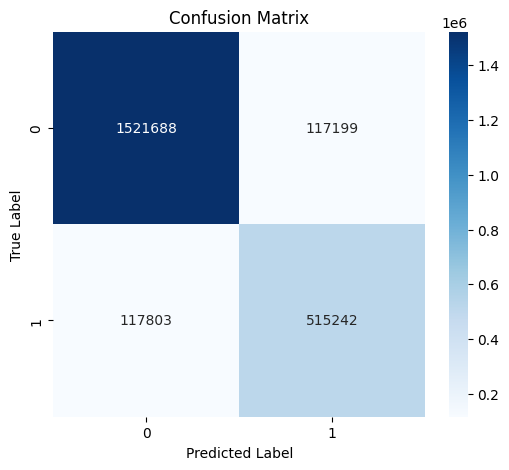

(0.8965629252988205, 0.8142990123952378, 0.8146878523055906, 0.8139105434842705, 0.2612321674823761)


In [24]:
model.load_state_dict(torch.load(model_checkpoint_path_feedforward_nn)) # load model with the best validation accuracy
result = evaluate(test_loader, model) # perform an evaluation on the test split

wandb.finish() #ปิดการเชื่อมต่อกับ Weights & Biases
print(result)


# TODO 1, 2 - Debugging

In order to understand what is going on in your model and where the error is, you should try looking at the inputs your model made wrong predictions.

In this task, write a function to print the characters on test data that got wrong prediction along with its context of size 10 (from [x-10] to [x+10]). Examine a fews of those and write your assumption on where the model got wrong prediction.

In [25]:
def convert_indices_to_chars(indices, char_map):
    indices = np.concatenate((indices[10:20][::-1], indices[-1:], indices[0:10]))
    index_to_char = {v: k for k, v in char_map.items()}  # Reverse the mapping
    return "".join(index_to_char.get(int(idx), "?") for idx in indices)  # Convert and handle unknown indices

def show_wrong_predictions(model, test_loader, criterion, device='cpu', context_size=10, idx_to_char=None):
    model.eval()
    wrong_samples = []

    with torch.no_grad():
        for X_test, Y_test in test_loader:
            X_test, Y_test = X_test.to(device), Y_test.to(device)
            Y_pred = model(X_test)

            # If multi-class classification, use argmax
            pred_labels = (Y_pred > 0.5).cpu().numpy().flatten()
            true_labels = Y_test.cpu().numpy().flatten()

            # Find misclassified indices
            misclassified_indices = np.where(pred_labels != true_labels)[0]

            for idx in misclassified_indices:
                # Extract input character indices for the corresponding sample
                input_chars = X_test[idx].cpu().numpy()

                # Convert to readable characters
                char_context = convert_indices_to_chars(input_chars, idx_to_char) if idx_to_char else input_chars

                wrong_samples.append((idx, true_labels[idx], pred_labels[idx], char_context))

    # Print results
    print("Misclassified samples with context:")
    for idx, true_label, pred_label, char_context in wrong_samples[:10]:  # Show a few wrong predictions
        true_char = str(int(true_label))  # Convert to string to ensure proper formatting
        pred_char = str(int(pred_label))  # Convert to string to ensure proper formatting
        print(f"Index: {idx}, True: {true_char}, Pred: {pred_char}, Context: {char_context}, Input_Char: {char_context[10]}")

    return wrong_samples


In [28]:
# TODO#1
# Write code to show a few of the errors the models made.
# Assuming you have a trained model, test_loader, and idx_to_char mapping
wandb.init(
    project='simpleff',
    config=config,
)

wrong_cases = show_wrong_predictions(model, test_loader, criterion, device="cuda", idx_to_char=CHARS_MAP)
wandb.finish() #ปิดการเชื่อมต่อกับ Weights & Biases

pass

Misclassified samples with context:
Index: 6, True: 1, Pred: 0, Context:     ปฏิรูปการศึกษา : , Input_Char: ก
Index: 40, True: 1, Pred: 0, Context: วนทัศน์และบริบทสังคมไ, Input_Char: บ
Index: 45, True: 1, Pred: 0, Context: น์และบริบทสังคมไทยThe, Input_Char: ส
Index: 48, True: 0, Pred: 1, Context: ละบริบทสังคมไทยThe Re, Input_Char: ค
Index: 50, True: 1, Pred: 0, Context: บริบทสังคมไทยThe Refo, Input_Char: ไ
Index: 51, True: 0, Pred: 1, Context: ริบทสังคมไทยThe Refor, Input_Char: ท
Index: 95, True: 0, Pred: 1, Context:  A Thai Perspectiveกร, Input_Char: r
Index: 125, True: 1, Pred: 0, Context: และวิธีคิดแบบแยกส่วน , Input_Char: แ
Index: 127, True: 0, Pred: 1, Context: ะวิธีคิดแบบแยกส่วน ลด, Input_Char: บ
Index: 128, True: 1, Pred: 0, Context: วิธีคิดแบบแยกส่วน ลดส, Input_Char: แ


## Write your answer here

**Your answer**: TODO#2

# TODO 3, 4 - Dropout

You might notice that the 3-layered feedforward does not use dropout at all. Now, try adding dropout to the model, run, and report the result again.

In [29]:
################################################################################
# TODO#3:                                                                      #
# Write a model class that return feedforward model with dropout.              #
################################################################################

class SimpleFeedforwardNNWDropout(torch.nn.Module):
    # การสร้างโมเดล (define model layers)
  def __init__(self,dropout_rate = 0.1):
    super(SimpleFeedforwardNNWDropout, self).__init__() #ใช้เรียกฟังก์ชันของคลาสหลัก เพื่อให้สามารถใช้คุณสมบัติของ torch.nn.Module ได้
    
    
    # การกำหนดโครงสร้างของ Neural Network
    # สร้างชั้นของ Fully Connected Layers (Define Fully Connected Layers) #โมเดลนี้มี 3 ชั้นซ่อน (Hidden Layers) และ 1 ชั้นเอาต์พุต (Output Layer)
    self.mlp1 = torch.nn.Linear(21, 100)  # อินพุตมี 21 นิวรอน ส่งไปยัง 100 นิวรอน (Input: 21 neurons -> 100 neurons)
    self.mlp2 = torch.nn.Linear(100, 100) # hidden ที่มี 100 นิวรอน (Hidden layer: 100 neurons)
    self.mlp3 = torch.nn.Linear(100, 100) # hidden อีกชั้น (Another hidden layer: 100 neurons)
    self.cls_head = torch.nn.Linear(100, 1)  # เอาต์พุตเป็น 1 นิวรอน (Output layer: 1 neuron)
    self.dropout = torch.nn.Dropout(p=dropout_rate)
    
    # การกำหนดการไหลของข้อมูลในโมเดล
  def forward(self, x):
    x = F.relu(self.mlp1(x))  # ใช้ ReLU Activation (Apply ReLU activation)
    x = F.relu(self.mlp2(x))
    x = self.dropout(x)
    x = F.relu(self.mlp3(x))
    x = self.dropout(x)
    x = self.cls_head(x)  # ไม่มี Activation Function ที่ output layer (No activation function at the output layer)
    out = torch.sigmoid(x)  # ใช้ Sigmoid เพื่อให้ค่าผลลัพธ์อยู่ในช่วง [0,1] (Use Sigmoid to get values in the range [0,1])
    return out

In [ ]:
################################################################################
# TODO#4:                                                                      #
# Write code that performs a training process. Select your batch size carefully#
# as it will affect your model's ability to converge and                       #
# time needed for one epoch.                                                   #
################################################################################
# Complete the code to train your model with dropout
model_nn_with_dropout = SimpleFeedforwardNNWDropout().cuda()
# summary(model_nn_with_dropout,  torch.zeros((1, 21), dtype = torch.float).cuda() ) #summarize the model# TODO#4
summary(model_nn_with_dropout, input_size=(1, 21))
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################

NUM_EPOCHS = 3 # จำนวนรอบการฝึก (epochs)
model_dropout_checkpoint_path_feedforward_nn = './model_dropout_weight_feedforward_nn.h5' # ไฟล์สำหรับบันทึกน้ำหนักของโมเดล
criterion = torch.nn.BCELoss(reduction = 'none') # ฟังก์ชัน Loss สำหรับ Binary Classification
BATCHS_SIZE = 512  # ขนาดของ Batch
optimizer = optim.Adam(model_nn_with_dropout.parameters(), lr=5e-4) # ใช้ Adam optimizer ในการอัปเดตค่าถ่วงน้ำหนัก
eps = 1e-10 # ค่าคงที่ขนาดเล็กเพื่อป้องกันการหารด้วยศูนย์

wandb.init(project="simpleff",config={
    'architecture': 'Dropout',
    'epochs': 3
})  # Start a new W&B run



In [31]:
# ติดตามการฝึกโมเดลด้วย Weights & Biases (Track the model training with Weights & Biases)
wandb.watch(model_nn_with_dropout, log='all')


idx = 0 # ใช้นับจำนวนรอบการอัปเดตพารามิเตอร์ (iterations)
best_val_acc = 0 #ใช้เก็บค่าความแม่นยำสูงสุดที่ได้จาก validation

# เริ่มต้นรอบการฝึก (Training loop for NUM_EPOCHS)
for n_epoch in range(NUM_EPOCHS):
    print("EPOCH :", n_epoch + 1)  # แสดงหมายเลขรอบฝึก (Print current epoch number)

    model_nn_with_dropout.train() # set โมเดลให้อยู่ในโหมดการฝึก (Set the model to training mode)
    print("TRAINING LOOP")

    # วนลูปฝึกแต่ละ batch จาก train_loader (Iterate through training batches)
    for X_train, Y_train in tqdm(train_loader): # วนลูปแต่ละ batch ของข้อมูลฝึก
        optimizer.zero_grad()  # เคลียร์ gradient ของรอบที่แล้ว (Clear gradients from previous step)
        Y_pred = model_nn_with_dropout(X_train)  # คำนวณค่าทำนาย (Make predictions)
        loss = criterion(Y_pred, Y_train).mean()  # คำนวณ loss (Calculate the loss)
        loss.backward()  # คำนวณ gradients (Backpropagation)
        optimizer.step()  # อัปเดตพารามิเตอร์โมเดล (Update model parameters)

        # บันทึกข้อมูลการฝึกใน WandB (Log training loss and iteration count to WandB)
        wandb.log({
            'train_loss': loss,  # ค่าความสูญเสียในการฝึก (Training loss)
            'n_iter' : idx  # จำนวนการวนรอบ (Iteration count)
        })

        idx += 1  # เพิ่มค่าจำนวน Iteration

    # เริ่ม validation loop (Validation loop: ใช้ accuracy เป็นเมตริกหลัก) (Validation loop for simplicity using accuracy as the primary metric)
    model_nn_with_dropout.eval()  # set โมเดลให้อยู่ในโหมด validation (Set the model to evaluation mode)
    with torch.no_grad():  # ปิดการคำนวณ gradient สำหรับ validation (Disable gradient computation)
        print("VALIDATION LOOP")

        # ตัวแปรเก็บข้อมูลสำหรับการ validation (Initialize variables for validation data)
        val_loss = []
        val_pred = []
        val_true = []

        for X_val, Y_val in tqdm(val_loader): # วนลูปแต่ละ batch ของ validation
            Y_pred = model_nn_with_dropout(X_val)  # คำนวณค่าทำนายจาก validation (Make predictions on validation data)
            loss = criterion(Y_pred, Y_val)  # คำนวณค่า loss (Calculate the loss)

            # เก็บข้อมูล loss และค่าทำนายใน validation (Store loss and predictions)
            val_loss.append(loss)
            val_pred.append(Y_pred)
            val_true.append(Y_val)

        # คำนวณค่า loss และความแม่นยำเฉลี่ยในการ validation (Calculate average validation loss and accuracy)
        avg_val_loss = torch.concatenate(val_loss, axis = 0).mean().item()  # ค่า loss เฉลี่ยในการ validation (Average validation loss)
        val_pred = torch.concatenate(val_pred, axis = 0).cpu().detach().numpy()  # ค่าทำนายในการ validation (Validation predictions) #Tensor → NumPy Array
        val_true = torch.concatenate(val_true, axis = 0).cpu().detach().numpy()  # ค่าจริงในการ validation (True values for validation) #Tensor → NumPy Array

        # แปลงค่าทำนายเป็นคลาส (0 หรือ 1) (Convert predictions to class labels)
        prob_to_class = lambda p: 1 if p[0]>=0.5 else 0
        val_pred = np.apply_along_axis(prob_to_class,1,val_pred)

        # คำนวณความแม่นยำในการ validation (Calculate accuracy)
        val_acc = accuracy_score(val_true, val_pred)

        print("val loss:", avg_val_loss)  # แสดงค่า loss ของ validation (Print validation loss)
        print("val accuracy:", val_acc)  # แสดงความแม่นยำของ validation (Print validation accuracy)

        # ถ้าความแม่นยำในการ validation ดีที่สุด ให้บันทึกโมเดล (Save the model if validation accuracy improves)
        if(best_val_acc < val_acc):
            best_val_acc = val_acc
            torch.save(model_nn_with_dropout.state_dict(), model_dropout_checkpoint_path_feedforward_nn)  # บันทึกพารามิเตอร์ของโมเดล (Save model parameters)

        # บันทึกข้อมูลการ validation ใน WandB (Log validation accuracy and loss to WandB)
        wandb.log({
            'val_accuracy' : val_acc,  # ความแม่นยำในการ validation (Validation accuracy)
            'val_loss': avg_val_loss,  # ค่า loss ของ validation (Validation loss)
        })


EPOCH : 1
TRAINING LOOP


100%|██████████| 32152/32152 [02:05<00:00, 257.02it/s]


VALIDATION LOOP


100%|██████████| 3976/3976 [00:11<00:00, 357.80it/s]


val loss: 0.3288961350917816
val accuracy: 0.8594361431531458
EPOCH : 2
TRAINING LOOP


100%|██████████| 32152/32152 [02:13<00:00, 241.37it/s]


VALIDATION LOOP


100%|██████████| 3976/3976 [00:11<00:00, 360.09it/s]


val loss: 0.31204161047935486
val accuracy: 0.8680887206033913
EPOCH : 3
TRAINING LOOP


100%|██████████| 32152/32152 [02:04<00:00, 258.20it/s]


VALIDATION LOOP


100%|██████████| 3976/3976 [00:11<00:00, 359.89it/s]


val loss: 0.2937262952327728
val accuracy: 0.8775243234002753


C:\Users\Aitthikit\AppData\Local\Temp\ipykernel_32980\1857744595.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_nn_with_dropout.load_state_dict(torch.load(model_d

100%|██████████| 4438/4438 [00:13<00:00, 333.62it/s]


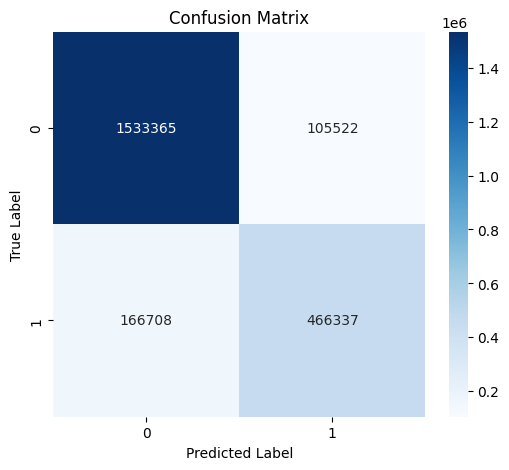

n_iter,▁▁▁▁▁▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇██
train_loss,▇▄▂▆▅▅▂▇█▃▄▆▁▄▃▂▂▂▅▃▄▄▂▃▂▃▃▂▃▁▁▂▃▂▃▃▃▂▂▃
val_accuracy,▁▄█
val_loss,█▅▁
n_iter,96455
train_loss,0.26575
val_accuracy,0.87752
val_loss,0.29373


(0.8801768714908721, 0.7740649877500614, 0.8154754930848338, 0.7366569517174925, 0.2901938259601593)


In [ ]:
model_nn_with_dropout.load_state_dict(torch.load(model_dropout_checkpoint_path_feedforward_nn))
result = evaluate(test_loader, model_nn_with_dropout)
test_loader = DataLoader(Dataset(x_test_char, y_test, dtype = 'float'), batch_size = BATCHS_SIZE)
wrong_cases = show_wrong_predictions(model_nn_with_dropout, test_loader, criterion, device="cuda", idx_to_char=CHARS_MAP)
wandb.finish() #ปิดการเชื่อมต่อกับ Weights & Biases

print(result)

# TODO 5, 6 - Convolution Neural Networks

Now, you are going to implement you own 1d-convolution neural networks with the following structure:

Now, you are going to implement you own 1d-convolution neural networks with the following structure:
input (size 21) -> embedding layer (size 32) -> 1D-convolution layer (100 filters of size 5, strides of 1) -> Dense size 5 (applied across time dimension) -> fully-connected layer (size 100) -> output (size 1).

These parameters are simple guidelines to save your time. You can play with them in the final section.

The results should be better than the feedforward model.

Embedding layers turn the input from a one-hot vector into better representations via some feature transform (a simple matrix multiply in this case).



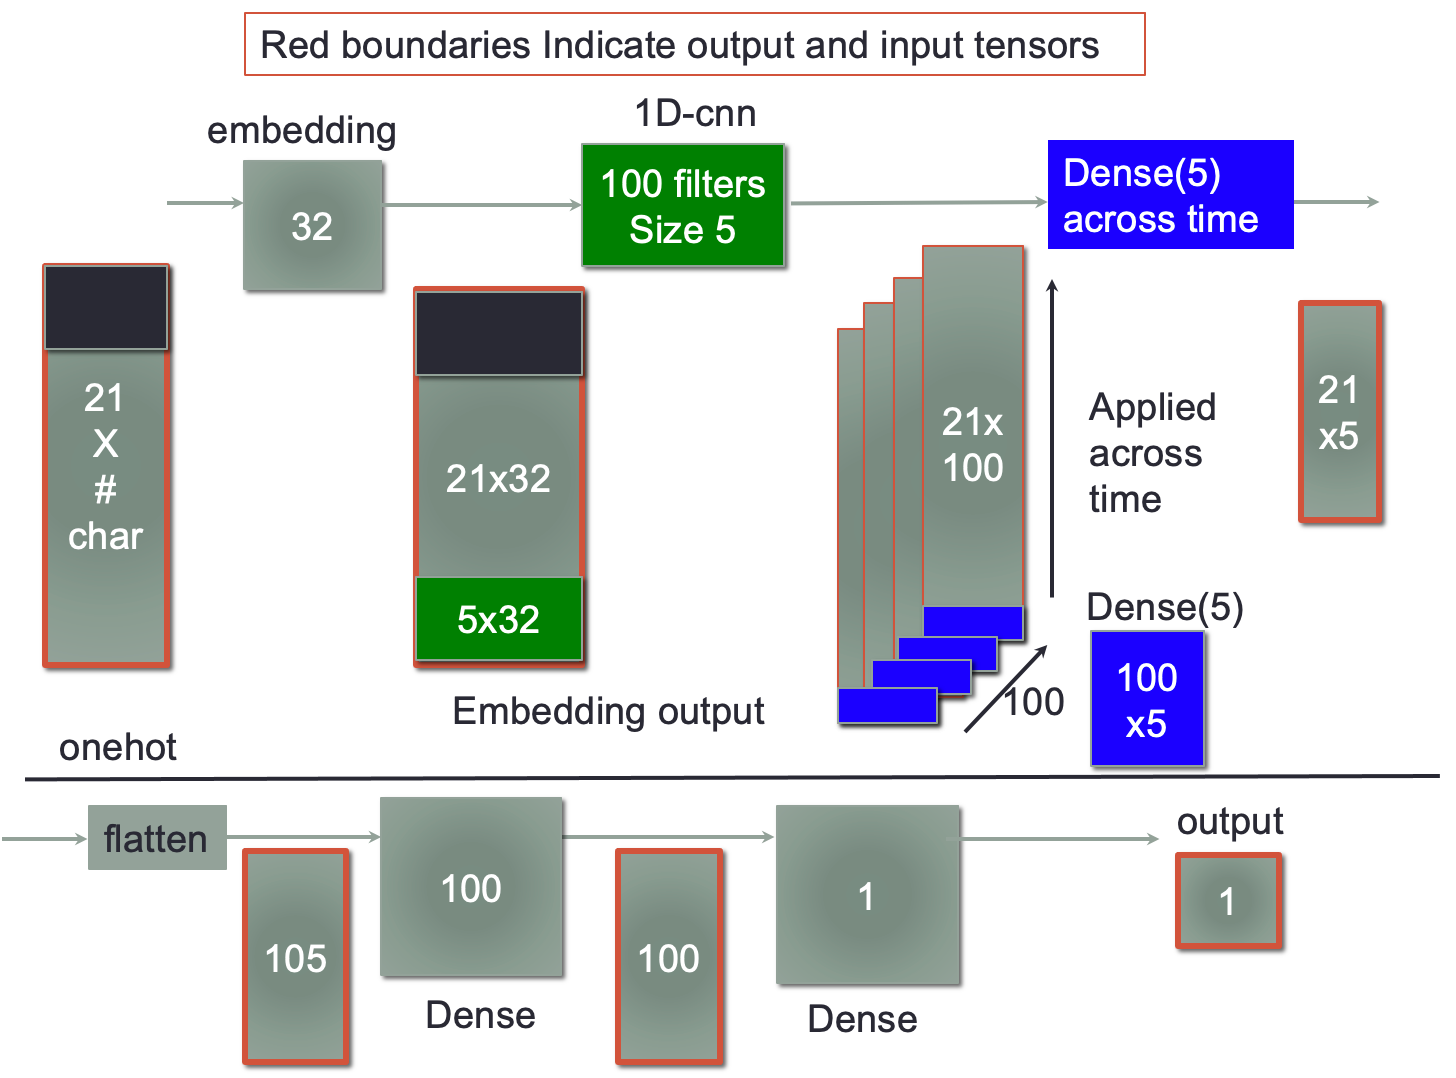


Note you need to flatten the tensor before the final fully connected layer because of dimension mis-match. The tensor could be reshaped using the `view` method.

Do consult PyTorch documentation on how to use [embedding layers](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) and [1D-cnn](https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html).

Hint: to apply dense5 across the time dimension you should read about how the multiplication in the dense layer is applied. The output of the 1D-cnn should be [batch x nfilter x sequence length]. We want to apply the dense5 (a weight matrix of size 100 x 5) by multiplying the same set of numbers over the nfilter dimension repeated over the sequence length (this can be possible via broadcasting) which should give an output of [batch x 5 x sequence length]. You might want to use the function [transpose](https://pytorch.org/docs/stable/generated/torch.transpose.html) somehow.

Even more hints: https://stackoverflow.com/questions/58587057/multi-dimensional-inputs-in-pytorch-linear-method


In [27]:
################################################################################
# TODO#5:                                                                      #
# Write a function that returns convolution nueral network model.              #
# You can choose any normalization methods, activation function, as well as    #
# any hyperparameter the way you want. Your goal is to predict a score         #
# between [0,1] for each input whether it is the beginning of the word or not. #
#                                                                              #
# Hint: You should read PyTorch documentation to see the list of available     #
# layers and options you can use.                                              #
################################################################################

class SimpleCNN(torch.nn.Module):
    # การสร้างโมเดล (define model layers)
  def __init__(self,dropout_rate = 0.1):
    super(SimpleCNN, self).__init__() #ใช้เรียกฟังก์ชันของคลาสหลัก เพื่อให้สามารถใช้คุณสมบัติของ torch.nn.Module ได้
    
    self.embedding = torch.nn.Embedding(178,32)
    self.conv1d = torch.nn.Conv1d(in_channels=32,out_channels=100,kernel_size=5,padding="same")
    self.dense_time = torch.nn.Linear(100,5)
    self.flatten = torch.nn.Flatten()
    # การกำหนดโครงสร้างของ Neural Network
    # สร้างชั้นของ Fully Connected Layers (Define Fully Connected Layers) #โมเดลนี้มี 3 ชั้นซ่อน (Hidden Layers) และ 1 ชั้นเอาต์พุต (Output Layer)
    self.mlp1 = torch.nn.Linear(21*5, 100)  # อินพุตมี 21 นิวรอน ส่งไปยัง 100 นิวรอน (Input: 21 neurons -> 100 neurons)
    self.cls_head = torch.nn.Linear(100, 1)  # เอาต์พุตเป็น 1 นิวรอน (Output layer: 1 neuron)
    self.dropout = torch.nn.Dropout(p=dropout_rate)
    
    # การกำหนดการไหลของข้อมูลในโมเดล
  def forward(self, x):
     # Embedding Layer
      x = self.embedding(x)  # Output: (batch_size, 21, 32)
      
      # Conv1D Layer (Change shape for Conv1D)
      x = x.permute(0, 2, 1)  # Change shape to (batch_size, 32, 21) for Conv1D
      x = F.relu(self.conv1d(x))  # Output: (batch_size, 100, ?)
      x = x.permute(0, 2, 1)  # Back to (batch_size, 21, 100)

      # Dense across time (apply fully connected layer across time steps)
      x = F.relu(self.dense_time(x))  # Output: (batch_size, 21, 5)

      # Flatten and Pass through MLP
      x = self.flatten(x)  # Output: (batch_size, 21*5)
      x = F.relu(self.mlp1(x))
      x = self.cls_head(x)  # No activation for final output
      out = torch.sigmoid(x)  # ใช้ Sigmoid เพื่อให้ค่าผลลัพธ์อยู่ในช่วง [0,1] (Use Sigmoid to get values in the range [0,1])
      return out

In [28]:
################################################################################
# TODO#6:                                                                      #
# Write code that performs a training process. Select your batch size carefully#
# as it will affect your model's ability to converge and                       #
# time needed for one epoch.                                                   #
################################################################################
model_conv1d_nn = SimpleCNN().cuda()
# summary(model_conv1d_nn,  torch.zeros((64, 21), dtype = torch.long).cuda() ) #summarize the model
summary(model_conv1d_nn, input_size=(1, 21), dtypes = [torch.long])
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
NUM_EPOCHS = 3 # จำนวนรอบการฝึก (epochs)
model_CNN_checkpoint_path_feedforward_nn = './model_CNN.h5' # ไฟล์สำหรับบันทึกน้ำหนักของโมเดล
criterion = torch.nn.BCELoss(reduction = 'none') # ฟังก์ชัน Loss สำหรับ Binary Classification
BATCHS_SIZE = 512  # ขนาดของ Batch
optimizer = optim.Adam(model_conv1d_nn.parameters(), lr=5e-4) # ใช้ Adam optimizer ในการอัปเดตค่าถ่วงน้ำหนัก
eps = 1e-10 # ค่าคงที่ขนาดเล็กเพื่อป้องกันการหารด้วยศูนย์
print(summary(model_conv1d_nn, input_size=(1, 21), dtypes = [torch.long]))

wandb.init(project="simpleff",config={
    'architecture': 'CNN',
    'epochs': 3},name="CNN")  # Start a new W&B run

Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN                                [1, 1]                    --
├─Embedding: 1-1                         [1, 21, 32]               5,696
├─Conv1d: 1-2                            [1, 100, 21]              16,100
├─Linear: 1-3                            [1, 21, 5]                505
├─Flatten: 1-4                           [1, 105]                  --
├─Linear: 1-5                            [1, 100]                  10,600
├─Linear: 1-6                            [1, 1]                    101
Total params: 33,002
Trainable params: 33,002
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.36
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.13
Estimated Total Size (MB): 0.16


In [29]:
# ติดตามการฝึกโมเดลด้วย Weights & Biases (Track the model training with Weights & Biases)
wandb.watch(model_conv1d_nn, log='all')


idx = 0 # ใช้นับจำนวนรอบการอัปเดตพารามิเตอร์ (iterations)
best_val_acc = 0 #ใช้เก็บค่าความแม่นยำสูงสุดที่ได้จาก validation

# เริ่มต้นรอบการฝึก (Training loop for NUM_EPOCHS)
for n_epoch in range(NUM_EPOCHS):
    print("EPOCH :", n_epoch + 1)  # แสดงหมายเลขรอบฝึก (Print current epoch number)

    model_conv1d_nn.train() # set โมเดลให้อยู่ในโหมดการฝึก (Set the model to training mode)
    print("TRAINING LOOP")

    # วนลูปฝึกแต่ละ batch จาก train_loader (Iterate through training batches)
    for X_train, Y_train in tqdm(train_loader): # วนลูปแต่ละ batch ของข้อมูลฝึก
        # print("Before conversion:", X_train.dtype)  # Should be torch.float32
        X_train = X_train.long()
        # print("After conversion:", X_train.dtype)  # Should be torch.int64
        # print(f"Min index: {X_train.min()}, Max index: {X_train.max()}")
        # break
        optimizer.zero_grad()  # เคลียร์ gradient ของรอบที่แล้ว (Clear gradients from previous step)
        Y_pred = model_conv1d_nn(X_train)  # คำนวณค่าทำนาย (Make predictions)
        loss = criterion(Y_pred, Y_train).mean()  # คำนวณ loss (Calculate the loss)
        loss.backward()  # คำนวณ gradients (Backpropagation)
        optimizer.step()  # อัปเดตพารามิเตอร์โมเดล (Update model parameters)

        # บันทึกข้อมูลการฝึกใน WandB (Log training loss and iteration count to WandB)
        wandb.log({
            'train_loss': loss,  # ค่าความสูญเสียในการฝึก (Training loss)
            'n_iter' : idx  # จำนวนการวนรอบ (Iteration count)
        })

        idx += 1  # เพิ่มค่าจำนวน Iteration

    # เริ่ม validation loop (Validation loop: ใช้ accuracy เป็นเมตริกหลัก) (Validation loop for simplicity using accuracy as the primary metric)
    model_conv1d_nn.eval()  # set โมเดลให้อยู่ในโหมด validation (Set the model to evaluation mode)
    with torch.no_grad():  # ปิดการคำนวณ gradient สำหรับ validation (Disable gradient computation)
        print("VALIDATION LOOP")

        # ตัวแปรเก็บข้อมูลสำหรับการ validation (Initialize variables for validation data)
        val_loss = []
        val_pred = []
        val_true = []

        for X_val, Y_val in tqdm(val_loader): # วนลูปแต่ละ batch ของ validation
            X_val = X_val.long()
            Y_pred = model_conv1d_nn(X_val)  # คำนวณค่าทำนายจาก validation (Make predictions on validation data)
            loss = criterion(Y_pred, Y_val)  # คำนวณค่า loss (Calculate the loss)

            # เก็บข้อมูล loss และค่าทำนายใน validation (Store loss and predictions)
            val_loss.append(loss)
            val_pred.append(Y_pred)
            val_true.append(Y_val)

        # คำนวณค่า loss และความแม่นยำเฉลี่ยในการ validation (Calculate average validation loss and accuracy)
        avg_val_loss = torch.concatenate(val_loss, axis = 0).mean().item()  # ค่า loss เฉลี่ยในการ validation (Average validation loss)
        val_pred = torch.concatenate(val_pred, axis = 0).cpu().detach().numpy()  # ค่าทำนายในการ validation (Validation predictions) #Tensor → NumPy Array
        val_true = torch.concatenate(val_true, axis = 0).cpu().detach().numpy()  # ค่าจริงในการ validation (True values for validation) #Tensor → NumPy Array

        # แปลงค่าทำนายเป็นคลาส (0 หรือ 1) (Convert predictions to class labels)
        prob_to_class = lambda p: 1 if p[0]>=0.5 else 0
        val_pred = np.apply_along_axis(prob_to_class,1,val_pred)

        # คำนวณความแม่นยำในการ validation (Calculate accuracy)
        val_acc = accuracy_score(val_true, val_pred)

        print("val loss:", avg_val_loss)  # แสดงค่า loss ของ validation (Print validation loss)
        print("val accuracy:", val_acc)  # แสดงความแม่นยำของ validation (Print validation accuracy)

        # ถ้าความแม่นยำในการ validation ดีที่สุด ให้บันทึกโมเดล (Save the model if validation accuracy improves)
        if(best_val_acc < val_acc):
            best_val_acc = val_acc
            torch.save(model_conv1d_nn.state_dict(), model_CNN_checkpoint_path_feedforward_nn)  # บันทึกพารามิเตอร์ของโมเดล (Save model parameters)

        # บันทึกข้อมูลการ validation ใน WandB (Log validation accuracy and loss to WandB)
        wandb.log({
            'val_accuracy' : val_acc,  # ความแม่นยำในการ validation (Validation accuracy)
            'val_loss': avg_val_loss,  # ค่า loss ของ validation (Validation loss)
        })

EPOCH : 1
TRAINING LOOP


100%|██████████| 32152/32152 [02:34<00:00, 208.61it/s]


VALIDATION LOOP


100%|██████████| 3976/3976 [00:11<00:00, 335.02it/s]


val loss: 0.098788321018219
val accuracy: 0.964057466397209
EPOCH : 2
TRAINING LOOP


100%|██████████| 32152/32152 [02:27<00:00, 217.53it/s]


VALIDATION LOOP


100%|██████████| 3976/3976 [00:11<00:00, 336.33it/s]


val loss: 0.08779072016477585
val accuracy: 0.9683704918322695
EPOCH : 3
TRAINING LOOP


100%|██████████| 32152/32152 [02:33<00:00, 209.41it/s]


VALIDATION LOOP


100%|██████████| 3976/3976 [00:12<00:00, 329.47it/s]


val loss: 0.08160071074962616
val accuracy: 0.9707853930895312


In [30]:
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

################################################################################
# A function to evaluate your model. This function must take test dataloader   #
# and the input model to return f-score, precision, and recall of the model.   #
################################################################################
def evaluateCNN(test_loader, model):
  """
  Evaluate model on the splitted 10 percent testing set.
  """
  model.eval()
  with torch.no_grad():
    test_loss = []
    test_pred = []
    test_true = []
    for X_test, Y_test in tqdm(test_loader):
      X_test = X_test.long()
      Y_pred = model(X_test)
      loss = criterion(Y_pred, Y_test)
      test_loss.append(loss)
      test_pred.append(Y_pred)
      test_true.append(Y_test)

    avg_test_loss = torch.concatenate(test_loss, axis = 0).mean().item()
    test_pred = torch.concatenate(test_pred, axis = 0).cpu().detach().numpy()
    test_true = torch.concatenate(test_true, axis = 0).cpu().detach().numpy()

    prob_to_class = lambda p: 1 if p[0]>=0.5 else 0
    test_pred = np.apply_along_axis(prob_to_class,1,test_pred)

    acc = accuracy_score(test_true, test_pred)
    f1score = f1_score(test_true, test_pred)
    precision = precision_score(test_true, test_pred)
    recall = recall_score(test_true, test_pred)
    
   # Compute confusion matrix
    conf_matrix = confusion_matrix(test_true, test_pred)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

  return acc, f1score, precision, recall, avg_test_loss

def show_wrong_predictions_CNN(model, test_loader, criterion, device='cpu', context_size=10, idx_to_char=None):
    model.eval()
    wrong_samples = []

    with torch.no_grad():
        for X_test, Y_test in test_loader:
            X_test, Y_test = X_test.to(device), Y_test.to(device)
            X_test = X_test.long()
            Y_pred = model(X_test)

            # If multi-class classification, use argmax
            pred_labels = (Y_pred > 0.5).cpu().numpy().flatten()
            true_labels = Y_test.cpu().numpy().flatten()

            # Find misclassified indices
            misclassified_indices = np.where(pred_labels != true_labels)[0]

            for idx in misclassified_indices:
                # Extract input character indices for the corresponding sample
                input_chars = X_test[idx].cpu().numpy()

                # Convert to readable characters
                char_context = convert_indices_to_chars(input_chars, idx_to_char) if idx_to_char else input_chars

                wrong_samples.append((idx, true_labels[idx], pred_labels[idx], char_context))

    # Print results
    print("Misclassified samples with context:")
    for idx, true_label, pred_label, char_context in wrong_samples[:10]:  # Show a few wrong predictions
        true_char = str(int(true_label))  # Convert to string to ensure proper formatting
        pred_char = str(int(pred_label))  # Convert to string to ensure proper formatting
        print(f"Index: {idx}, True: {true_char}, Pred: {pred_char}, Context: {char_context}, Input_Char: {char_context[10]}")

    return wrong_samples

100%|██████████| 4438/4438 [00:13<00:00, 320.21it/s]


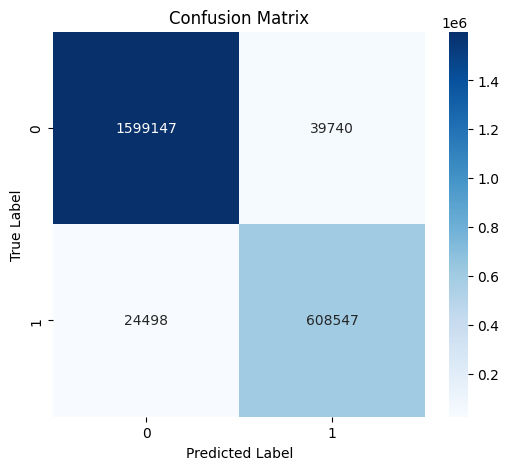

C:\Users\Aitthikit\AppData\Local\Temp\ipykernel_34256\1958045350.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_conv1d_nn.load_state_dict(torch.load(model_CNN_che

Misclassified samples with context:
Index: 20, True: 0, Pred: 1, Context: ึกษา : มุมมองทางกระบว, Input_Char: ม
Index: 32, True: 1, Pred: 0, Context: งทางกระบวนทัศน์และบริ, Input_Char: ท
Index: 104, True: 1, Pred: 0, Context: erspectiveกระบวนทัศน์, Input_Char: ก
Index: 110, True: 1, Pred: 0, Context: tiveกระบวนทัศน์และวิธ, Input_Char: ท
Index: 165, True: 0, Pred: 1, Context: ศึกษาเรียนรู้"ใน หลาย, Input_Char: ร
Index: 228, True: 0, Pred: 1, Context: รด้านศึกษาศาสตร์ ครุศ, Input_Char: ศ
Index: 294, True: 0, Pred: 1, Context: ะทรวงศึกษาธิการ ทบวงม, Input_Char: ธ
Index: 315, True: 0, Pred: 1, Context: หาวิทยาลัยฯ มาอย่างต่, Input_Char: ฯ
Index: 403, True: 1, Pred: 0, Context: าล) การจัดการศึกษาภาย, Input_Char: ก
Index: 423, True: 1, Pred: 0, Context: ยใต้กระบวนทัศน์และวิธ, Input_Char: ท


n_iter,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
train_loss,▇█▃▅▂▃▅▄▄▄▆▁▃▄▄▃▄▁▅▄▄▃▂▄▅▃▂▄▄▄▂▁▁▂▇▆▃▁█▅
val_accuracy,▁▅█
val_loss,█▄▁
n_iter,96455
train_loss,0.03094
val_accuracy,0.97079
val_loss,0.0816


(0.9717253861471206, 0.949866232951335, 0.9386999893565658, 0.961301329289387, 0.07837269455194473)


In [31]:
result = evaluateCNN(test_loader, model_conv1d_nn)
model_conv1d_nn.load_state_dict(torch.load(model_CNN_checkpoint_path_feedforward_nn))
test_loader = DataLoader(Dataset(x_test_char, y_test, dtype = 'float'), batch_size = BATCHS_SIZE)
wrong_cases = show_wrong_predictions_CNN(model_conv1d_nn, test_loader, criterion, device="cuda", idx_to_char=CHARS_MAP)
wandb.finish() #ปิดการเชื่อมต่อกับ Weights & Biases
print(result)

# TODO 7, 8 - GRU

Implement your GRU model with the following structure: input -> embedding layer (size 32) -> GRU layer (size 32) -> fully-connected layer (size 100) -> output.


These parameters are simple guidelines to save your time. You can play with them in the final section.

The result should be better than the feedforward model and at least on par with your CNN model.

Do consult Pytorch documentation on how to use [embedding layers](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) and [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html).


In [32]:
################################################################################
# TODO#7                                                                       #
# Write a function that returns GRU network moded. You can choose any          #
# normalization methods, activation function, as well as any hyperparameter    #
# the way you want. Your goal is to predict a score between [0,1] for each     #
# input whether it is the beginning of the word or not.                        #
#                                                                              #
# Hint: You should read PyTorch documentation to see the list of available     #
# layers and options you can use.                                              #
################################################################################

class SimpleGRU(torch.nn.Module):
 # การสร้างโมเดล (define model layers)
  def __init__(self,dropout_rate = 0.1):
    super(SimpleGRU, self).__init__() #ใช้เรียกฟังก์ชันของคลาสหลัก เพื่อให้สามารถใช้คุณสมบัติของ torch.nn.Module ได้
    
    self.embedding = torch.nn.Embedding(178,32)
    self.gru = torch.nn.GRU(32,32,2)
    
    # self.conv1d = torch.nn.Conv1d(in_channels=32,out_channels=100,kernel_size=5,padding="same")
    # self.dense_time = torch.nn.Linear(100,5)
    # self.flatten = torch.nn.Flatten()
    # การกำหนดโครงสร้างของ Neural Network
    # สร้างชั้นของ Fully Connected Layers (Define Fully Connected Layers) #โมเดลนี้มี 3 ชั้นซ่อน (Hidden Layers) และ 1 ชั้นเอาต์พุต (Output Layer)
    self.mlp1 = torch.nn.Linear(32, 100)  # อินพุตมี 21 นิวรอน ส่งไปยัง 100 นิวรอน (Input: 21 neurons -> 100 neurons)
    self.cls_head = torch.nn.Linear(100, 1)  # เอาต์พุตเป็น 1 นิวรอน (Output layer: 1 neuron)
    self.dropout = torch.nn.Dropout(p=dropout_rate)
    
    # การกำหนดการไหลของข้อมูลในโมเดล
  def forward(self, x):
     # Embedding Layer
      x = self.embedding(x)  # Output: (batch_size, 21, 32)
      
      # Conv1D Layer (Change shape for Conv1D)
      # x = x.permute(0, 2, 1)  # Change shape to (batch_size, 32, 21) for Conv1D
      x, _ = self.gru(x)  # Output: (batch_size, 100, ?)
      x = x[:, -1, :]
      # x = x.permute(0, 2, 1)  # Back to (batch_size, 21, 100)

      # Dense across time (apply fully connected layer across time steps)
      # x = F.relu(self.dense_time(x))  # Output: (batch_size, 21, 5)

      # Flatten and Pass through MLP
      # x = self.flatten(x)  # Output: (batch_size, 21*5)
      x = F.relu(self.mlp1(x))
      # x = F.relu(self.mlp2(x))
      x = self.cls_head(x)  # No activation for final output
      out = torch.sigmoid(x)  # ใช้ Sigmoid เพื่อให้ค่าผลลัพธ์อยู่ในช่วง [0,1] (Use Sigmoid to get values in the range [0,1])
      return out

In [33]:
################################################################################
# TODO#8                                                                      #
# Write code that perform a trainin loop on this dataset. Select your          #
# batch size carefully as it will affect your model's ability to converge and  #
# time needed for one epoch.                                                   #
################################################################################
model_gru_nn = SimpleGRU().cuda()
# summary(model_gru_nn,  torch.zeros((64, 21), dtype = torch.long).cuda() ) #summarize the model
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
summary(model_gru_nn, input_size=(1, 21), dtypes = [torch.long])
NUM_EPOCHS = 3 # จำนวนรอบการฝึก (epochs)
model_GRU_checkpoint_path_feedforward_nn = './model_GRU.h5' # ไฟล์สำหรับบันทึกน้ำหนักของโมเดล
criterion = torch.nn.BCELoss(reduction = 'none') # ฟังก์ชัน Loss สำหรับ Binary Classification
BATCHS_SIZE = 512  # ขนาดของ Batch
optimizer = optim.Adam(model_gru_nn.parameters(), lr=5e-4) # ใช้ Adam optimizer ในการอัปเดตค่าถ่วงน้ำหนัก
eps = 1e-10 # ค่าคงที่ขนาดเล็กเพื่อป้องกันการหารด้วยศูนย์
print(summary(model_gru_nn, input_size=(1, 21), dtypes = [torch.long]))

wandb.init(project="simpleff",name="GRU")


Layer (type:depth-idx)                   Output Shape              Param #
SimpleGRU                                [1, 1]                    --
├─Embedding: 1-1                         [1, 21, 32]               5,696
├─GRU: 1-2                               [1, 21, 32]               12,672
├─Linear: 1-3                            [1, 100]                  3,300
├─Linear: 1-4                            [1, 1]                    101
Total params: 21,769
Trainable params: 21,769
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.28
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.09
Estimated Total Size (MB): 0.10


In [35]:
# ติดตามการฝึกโมเดลด้วย Weights & Biases (Track the model training with Weights & Biases)
wandb.watch(model_gru_nn, log='all')


idx = 0 # ใช้นับจำนวนรอบการอัปเดตพารามิเตอร์ (iterations)
best_val_acc = 0 #ใช้เก็บค่าความแม่นยำสูงสุดที่ได้จาก validation

# เริ่มต้นรอบการฝึก (Training loop for NUM_EPOCHS)
for n_epoch in range(NUM_EPOCHS):
    print("EPOCH :", n_epoch + 1)  # แสดงหมายเลขรอบฝึก (Print current epoch number)

    model_gru_nn.train() # set โมเดลให้อยู่ในโหมดการฝึก (Set the model to training mode)
    print("TRAINING LOOP")

    # วนลูปฝึกแต่ละ batch จาก train_loader (Iterate through training batches)
    for X_train, Y_train in tqdm(train_loader): # วนลูปแต่ละ batch ของข้อมูลฝึก
        # print("Before conversion:", X_train.dtype)  # Should be torch.float32
        X_train = X_train.long()
        # print("After conversion:", X_train.dtype)  # Should be torch.int64
        # print(f"Min index: {X_train.min()}, Max index: {X_train.max()}")
        # break
        optimizer.zero_grad()  # เคลียร์ gradient ของรอบที่แล้ว (Clear gradients from previous step)
        Y_pred = model_gru_nn(X_train)  # คำนวณค่าทำนาย (Make predictions)
        loss = criterion(Y_pred, Y_train).mean()  # คำนวณ loss (Calculate the loss)
        loss.backward()  # คำนวณ gradients (Backpropagation)
        optimizer.step()  # อัปเดตพารามิเตอร์โมเดล (Update model parameters)

        # บันทึกข้อมูลการฝึกใน WandB (Log training loss and iteration count to WandB)
        wandb.log({
            'train_loss': loss,  # ค่าความสูญเสียในการฝึก (Training loss)
            'n_iter' : idx  # จำนวนการวนรอบ (Iteration count)
        })

        idx += 1  # เพิ่มค่าจำนวน Iteration

    # เริ่ม validation loop (Validation loop: ใช้ accuracy เป็นเมตริกหลัก) (Validation loop for simplicity using accuracy as the primary metric)
    model_gru_nn.eval()  # set โมเดลให้อยู่ในโหมด validation (Set the model to evaluation mode)
    with torch.no_grad():  # ปิดการคำนวณ gradient สำหรับ validation (Disable gradient computation)
        print("VALIDATION LOOP")

        # ตัวแปรเก็บข้อมูลสำหรับการ validation (Initialize variables for validation data)
        val_loss = []
        val_pred = []
        val_true = []

        for X_val, Y_val in tqdm(val_loader): # วนลูปแต่ละ batch ของ validation
            X_val = X_val.long()
            Y_pred = model_gru_nn(X_val)  # คำนวณค่าทำนายจาก validation (Make predictions on validation data)
            loss = criterion(Y_pred, Y_val)  # คำนวณค่า loss (Calculate the loss)

            # เก็บข้อมูล loss และค่าทำนายใน validation (Store loss and predictions)
            val_loss.append(loss)
            val_pred.append(Y_pred)
            val_true.append(Y_val)

        # คำนวณค่า loss และความแม่นยำเฉลี่ยในการ validation (Calculate average validation loss and accuracy)
        avg_val_loss = torch.concatenate(val_loss, axis = 0).mean().item()  # ค่า loss เฉลี่ยในการ validation (Average validation loss)
        val_pred = torch.concatenate(val_pred, axis = 0).cpu().detach().numpy()  # ค่าทำนายในการ validation (Validation predictions) #Tensor → NumPy Array
        val_true = torch.concatenate(val_true, axis = 0).cpu().detach().numpy()  # ค่าจริงในการ validation (True values for validation) #Tensor → NumPy Array

        # แปลงค่าทำนายเป็นคลาส (0 หรือ 1) (Convert predictions to class labels)
        prob_to_class = lambda p: 1 if p[0]>=0.5 else 0
        val_pred = np.apply_along_axis(prob_to_class,1,val_pred)

        # คำนวณความแม่นยำในการ validation (Calculate accuracy)
        val_acc = accuracy_score(val_true, val_pred)

        print("val loss:", avg_val_loss)  # แสดงค่า loss ของ validation (Print validation loss)
        print("val accuracy:", val_acc)  # แสดงความแม่นยำของ validation (Print validation accuracy)

        # ถ้าความแม่นยำในการ validation ดีที่สุด ให้บันทึกโมเดล (Save the model if validation accuracy improves)
        if(best_val_acc < val_acc):
            best_val_acc = val_acc
            torch.save(model_gru_nn.state_dict(), model_GRU_checkpoint_path_feedforward_nn)  # บันทึกพารามิเตอร์ของโมเดล (Save model parameters)

        # บันทึกข้อมูลการ validation ใน WandB (Log validation accuracy and loss to WandB)
        wandb.log({
            'val_accuracy' : val_acc,  # ความแม่นยำในการ validation (Validation accuracy)
            'val_loss': avg_val_loss,  # ค่า loss ของ validation (Validation loss)
        })

EPOCH : 1
TRAINING LOOP


100%|██████████| 32152/32152 [04:21<00:00, 123.16it/s]


VALIDATION LOOP


100%|██████████| 3976/3976 [00:16<00:00, 244.75it/s]


val loss: 0.0879795104265213
val accuracy: 0.968247192357987
EPOCH : 2
TRAINING LOOP


100%|██████████| 32152/32152 [04:04<00:00, 131.50it/s]


VALIDATION LOOP


100%|██████████| 3976/3976 [00:14<00:00, 281.99it/s]


val loss: 0.0867331475019455
val accuracy: 0.969034638801313
EPOCH : 3
TRAINING LOOP


100%|██████████| 32152/32152 [03:36<00:00, 148.35it/s]


VALIDATION LOOP


100%|██████████| 3976/3976 [00:14<00:00, 280.58it/s]


val loss: 0.08514031767845154
val accuracy: 0.9696349254848715


100%|██████████| 4438/4438 [00:14<00:00, 310.20it/s]


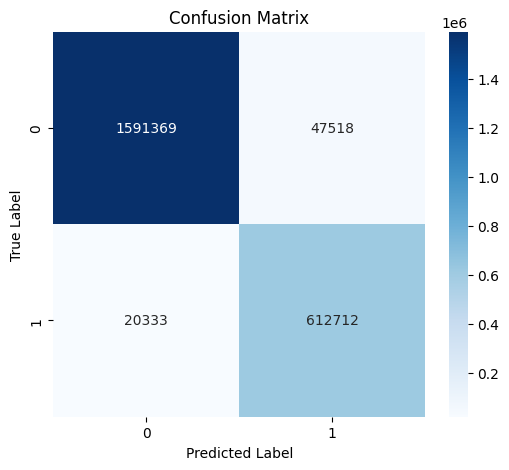

C:\Users\Aitthikit\AppData\Local\Temp\ipykernel_34256\1791378205.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_gru_nn.load_state_dict(torch.load(model_GRU_checkp

Misclassified samples with context:
Index: 0, True: 1, Pred: 0, Context:           ปฏิรูปการศึ, Input_Char: ป
Index: 6, True: 1, Pred: 0, Context:     ปฏิรูปการศึกษา : , Input_Char: ก
Index: 9, True: 1, Pred: 0, Context:  ปฏิรูปการศึกษา : มุม, Input_Char: ศ
Index: 20, True: 0, Pred: 1, Context: ึกษา : มุมมองทางกระบว, Input_Char: ม
Index: 44, True: 0, Pred: 1, Context: ศน์และบริบทสังคมไทยTh, Input_Char: ท
Index: 45, True: 1, Pred: 0, Context: น์และบริบทสังคมไทยThe, Input_Char: ส
Index: 165, True: 0, Pred: 1, Context: ศึกษาเรียนรู้"ใน หลาย, Input_Char: ร
Index: 228, True: 0, Pred: 1, Context: รด้านศึกษาศาสตร์ ครุศ, Input_Char: ศ
Index: 274, True: 0, Pred: 1, Context: งเรียน ครูอาจารย์ กระ, Input_Char: อ
Index: 294, True: 0, Pred: 1, Context: ะทรวงศึกษาธิการ ทบวงม, Input_Char: ธ


n_iter,▁▁▁▁▁▂▂▂▃▄▄▅▅▅▅▆▆▆▇▇▇█▁▂▂▃▃▃▃▃▄▄▄▅▆▆▇▇██
train_loss,█▂▂▆▂▄▃▂▃▂▃▂▅▃▂▂▃▁▂▂▂▃▃▁▃▂▁▂▂▂▃▃▂▃▂▁▂▂▂▂
val_accuracy,▁▅▇██
val_loss,█▅▂▁▁
n_iter,96455
train_loss,0.03164
val_accuracy,0.96963
val_loss,0.08514


(0.9701351096775784, 0.9475355202876419, 0.9280281114157187, 0.9678806403968122, 0.0829869732260704)


In [37]:
result = evaluateCNN(test_loader, model_gru_nn)
model_gru_nn.load_state_dict(torch.load(model_GRU_checkpoint_path_feedforward_nn))
test_loader = DataLoader(Dataset(x_test_char, y_test, dtype = 'float'), batch_size = BATCHS_SIZE)
wrong_cases = show_wrong_predictions_CNN(model_gru_nn, test_loader, criterion, device="cuda", idx_to_char=CHARS_MAP)
wandb.finish() #ปิดการเชื่อมต่อกับ Weights & Biases
print(result)

# TODO 9, 10 - Final Section
# PyTorch playground

Now, train the best model you can do for this task. You can use any model structure and function available. Remember that training time increases with the complexity of the model. You might find wandb helpful in tuning of complicated models.

Your model should be better than your CNN or GRU model in the previous sections.

Some ideas to try
1. Tune the parameters
2. Bi-directional GRU
3. CNN-GRU model
4. Improve the learning rate scheduling

In [38]:
################################################################################
# TODO#9                                                                       #
# Write a class that returns your best model. You can use anything             #
# you want. The goal here is to create the best model you can think of.        #
# Your model should get f-score more than 97% from calling evaluate().         #
#                                                                              #
# Hint: You should read PyTorch documentation to see the list of available     #
# layers and options you can use.                                              #
################################################################################

class BestModel(torch.nn.Module):
    # การสร้างโมเดล (define model layers)
  def __init__(self,dropout_rate = 0.1):
    super(BestModel, self).__init__() #ใช้เรียกฟังก์ชันของคลาสหลัก เพื่อให้สามารถใช้คุณสมบัติของ torch.nn.Module ได้
    
    self.embedding = torch.nn.Embedding(178,32)
    self.conv1d = torch.nn.Conv1d(in_channels=32,out_channels=100,kernel_size=5,padding="same")
    self.dense_time = torch.nn.Linear(100,5)
    self.flatten = torch.nn.Flatten()
    self.gru = torch.nn.GRU(21*5,100,1,bidirectional=True)
    self.mlp1 = torch.nn.Linear(200, 100)  # อินพุตมี  นิวรอน ส่งไปยัง 100 นิวรอน (Input: 21 neurons -> 100 neurons)
    self.cls_head = torch.nn.Linear(100, 1)  # เอาต์พุตเป็น 1 นิวรอน (Output layer: 1 neuron)
    self.dropout = torch.nn.Dropout(p=dropout_rate)
    
    # การกำหนดการไหลของข้อมูลในโมเดล
  def forward(self, x):
     # Embedding Layer
      x = self.embedding(x)  # Output: (batch_size, 21, 32)
      
      # Conv1D Layer (Change shape for Conv1D)
      x = x.permute(0, 2, 1)  # Change shape to (batch_size, 32, 21) for Conv1D
      x = F.relu(self.conv1d(x))  # Output: (batch_size, 100, ?)
      x = x.permute(0, 2, 1)  # Back to (batch_size, 21, 100)
      # Dense across time (apply fully connected layer across time steps)
      x = F.relu(self.dense_time(x))  # Output: (batch_size, 21, 5)
      
      # Flatten and Pass through MLP
      x = self.flatten(x)  # Output: (batch_size, 21*5)
      
      x, _ = self.gru(x)  # Output: (batch_size, 100, ?)
      x = F.relu(self.mlp1(x))
      x = self.dropout(x)
      x = self.cls_head(x)  # No activation for final output
      out = torch.sigmoid(x)  # ใช้ Sigmoid เพื่อให้ค่าผลลัพธ์อยู่ในช่วง [0,1] (Use Sigmoid to get values in the range [0,1])
      return out

In [39]:
################################################################################
# TODO#10                                                                      #
# Write code that perform a trainin loop on this dataset. Select your          #
# batch size carefully as it will affect your model's ability to converge and  #
# time needed for one epoch.                                                   #
#                                                                              #
################################################################################
print('start training')
my_best_model = BestModel().cuda()
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
summary(my_best_model, input_size=(1, 21), dtypes = [torch.long])
NUM_EPOCHS = 10 # จำนวนรอบการฝึก (epochs)
my_best_model_checkpoint_path_feedforward_nn = './model_Best.h5' # ไฟล์สำหรับบันทึกน้ำหนักของโมเดล
criterion = torch.nn.BCELoss(reduction = 'none') # ฟังก์ชัน Loss สำหรับ Binary Classification
BATCHS_SIZE = 512  # ขนาดของ Batch
optimizer = optim.Adam(my_best_model.parameters(), lr=5e-4) # ใช้ Adam optimizer ในการอัปเดตค่าถ่วงน้ำหนัก
eps = 1e-10 # ค่าคงที่ขนาดเล็กเพื่อป้องกันการหารด้วยศูนย์
print(summary(my_best_model, input_size=(1, 21), dtypes = [torch.long]))

wandb.init(project="simpleff",name="Best_model",config={
    'architecture': 'CNN+GRU+Dropout',
    'epochs': 10})


start training
Layer (type:depth-idx)                   Output Shape              Param #
BestModel                                [1, 1]                    --
├─Embedding: 1-1                         [1, 21, 32]               5,696
├─Conv1d: 1-2                            [1, 100, 21]              16,100
├─Linear: 1-3                            [1, 21, 5]                505
├─Flatten: 1-4                           [1, 105]                  --
├─GRU: 1-5                               [1, 200]                  124,200
├─Linear: 1-6                            [1, 100]                  20,100
├─Dropout: 1-7                           [1, 100]                  --
├─Linear: 1-8                            [1, 1]                    101
Total params: 166,702
Trainable params: 166,702
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 25.20
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.67
Estimated Total Size (MB): 0.69


In [40]:
# ติดตามการฝึกโมเดลด้วย Weights & Biases (Track the model training with Weights & Biases)
wandb.watch(my_best_model, log='all')


idx = 0 # ใช้นับจำนวนรอบการอัปเดตพารามิเตอร์ (iterations)
best_val_acc = 0 #ใช้เก็บค่าความแม่นยำสูงสุดที่ได้จาก validation

# เริ่มต้นรอบการฝึก (Training loop for NUM_EPOCHS)
for n_epoch in range(NUM_EPOCHS):
    print("EPOCH :", n_epoch + 1)  # แสดงหมายเลขรอบฝึก (Print current epoch number)

    my_best_model.train() # set โมเดลให้อยู่ในโหมดการฝึก (Set the model to training mode)
    print("TRAINING LOOP")

    # วนลูปฝึกแต่ละ batch จาก train_loader (Iterate through training batches)
    for X_train, Y_train in tqdm(train_loader): # วนลูปแต่ละ batch ของข้อมูลฝึก
        # print("Before conversion:", X_train.dtype)  # Should be torch.float32
        X_train = X_train.long()
        # print("After conversion:", X_train.dtype)  # Should be torch.int64
        # print(f"Min index: {X_train.min()}, Max index: {X_train.max()}")
        # break
        optimizer.zero_grad()  # เคลียร์ gradient ของรอบที่แล้ว (Clear gradients from previous step)
        Y_pred = my_best_model(X_train)  # คำนวณค่าทำนาย (Make predictions)
        loss = criterion(Y_pred, Y_train).mean()  # คำนวณ loss (Calculate the loss)
        loss.backward()  # คำนวณ gradients (Backpropagation)
        optimizer.step()  # อัปเดตพารามิเตอร์โมเดล (Update model parameters)

        # บันทึกข้อมูลการฝึกใน WandB (Log training loss and iteration count to WandB)
        wandb.log({
            'train_loss': loss,  # ค่าความสูญเสียในการฝึก (Training loss)
            'n_iter' : idx  # จำนวนการวนรอบ (Iteration count)
        })

        idx += 1  # เพิ่มค่าจำนวน Iteration

    # เริ่ม validation loop (Validation loop: ใช้ accuracy เป็นเมตริกหลัก) (Validation loop for simplicity using accuracy as the primary metric)
    my_best_model.eval()  # set โมเดลให้อยู่ในโหมด validation (Set the model to evaluation mode)
    with torch.no_grad():  # ปิดการคำนวณ gradient สำหรับ validation (Disable gradient computation)
        print("VALIDATION LOOP")

        # ตัวแปรเก็บข้อมูลสำหรับการ validation (Initialize variables for validation data)
        val_loss = []
        val_pred = []
        val_true = []

        for X_val, Y_val in tqdm(val_loader): # วนลูปแต่ละ batch ของ validation
            X_val = X_val.long()
            Y_pred = my_best_model(X_val)  # คำนวณค่าทำนายจาก validation (Make predictions on validation data)
            loss = criterion(Y_pred, Y_val)  # คำนวณค่า loss (Calculate the loss)

            # เก็บข้อมูล loss และค่าทำนายใน validation (Store loss and predictions)
            val_loss.append(loss)
            val_pred.append(Y_pred)
            val_true.append(Y_val)

        # คำนวณค่า loss และความแม่นยำเฉลี่ยในการ validation (Calculate average validation loss and accuracy)
        avg_val_loss = torch.concatenate(val_loss, axis = 0).mean().item()  # ค่า loss เฉลี่ยในการ validation (Average validation loss)
        val_pred = torch.concatenate(val_pred, axis = 0).cpu().detach().numpy()  # ค่าทำนายในการ validation (Validation predictions) #Tensor → NumPy Array
        val_true = torch.concatenate(val_true, axis = 0).cpu().detach().numpy()  # ค่าจริงในการ validation (True values for validation) #Tensor → NumPy Array

        # แปลงค่าทำนายเป็นคลาส (0 หรือ 1) (Convert predictions to class labels)
        prob_to_class = lambda p: 1 if p[0]>=0.5 else 0
        val_pred = np.apply_along_axis(prob_to_class,1,val_pred)

        # คำนวณความแม่นยำในการ validation (Calculate accuracy)
        val_acc = accuracy_score(val_true, val_pred)

        print("val loss:", avg_val_loss)  # แสดงค่า loss ของ validation (Print validation loss)
        print("val accuracy:", val_acc)  # แสดงความแม่นยำของ validation (Print validation accuracy)

        # ถ้าความแม่นยำในการ validation ดีที่สุด ให้บันทึกโมเดล (Save the model if validation accuracy improves)
        if(best_val_acc < val_acc):
            best_val_acc = val_acc
            torch.save(my_best_model.state_dict(), my_best_model_checkpoint_path_feedforward_nn)  # บันทึกพารามิเตอร์ของโมเดล (Save model parameters)

        # บันทึกข้อมูลการ validation ใน WandB (Log validation accuracy and loss to WandB)
        wandb.log({
            'val_accuracy' : val_acc,  # ความแม่นยำในการ validation (Validation accuracy)
            'val_loss': avg_val_loss,  # ค่า loss ของ validation (Validation loss)
        })

EPOCH : 1
TRAINING LOOP


100%|██████████| 32152/32152 [03:52<00:00, 138.40it/s]


VALIDATION LOOP


100%|██████████| 3976/3976 [00:16<00:00, 240.53it/s]


val loss: 0.07418055832386017
val accuracy: 0.9739671090055775
EPOCH : 2
TRAINING LOOP


100%|██████████| 32152/32152 [04:26<00:00, 120.57it/s]


VALIDATION LOOP


100%|██████████| 3976/3976 [00:13<00:00, 285.09it/s]


val loss: 0.05957268923521042
val accuracy: 0.9789359304492719
EPOCH : 3
TRAINING LOOP


100%|██████████| 32152/32152 [02:53<00:00, 185.23it/s]


VALIDATION LOOP


100%|██████████| 3976/3976 [00:14<00:00, 283.19it/s]


val loss: 0.054674144834280014
val accuracy: 0.9807878787283354
EPOCH : 4
TRAINING LOOP


100%|██████████| 32152/32152 [02:52<00:00, 186.43it/s]


VALIDATION LOOP


100%|██████████| 3976/3976 [00:12<00:00, 316.03it/s]


val loss: 0.05436629056930542
val accuracy: 0.9812373568915564
EPOCH : 5
TRAINING LOOP


100%|██████████| 32152/32152 [03:16<00:00, 163.51it/s]


VALIDATION LOOP


100%|██████████| 3976/3976 [00:13<00:00, 297.11it/s]


val loss: 0.05210311710834503
val accuracy: 0.982166769661845
EPOCH : 6
TRAINING LOOP


100%|██████████| 32152/32152 [02:54<00:00, 184.35it/s]


VALIDATION LOOP


100%|██████████| 3976/3976 [00:12<00:00, 313.34it/s]


val loss: 0.05094556882977486
val accuracy: 0.982661932490836
EPOCH : 7
TRAINING LOOP


100%|██████████| 32152/32152 [02:52<00:00, 186.74it/s]


VALIDATION LOOP


100%|██████████| 3976/3976 [00:12<00:00, 314.50it/s]


val loss: 0.04973819851875305
val accuracy: 0.9830342870785098
EPOCH : 8
TRAINING LOOP


100%|██████████| 32152/32152 [02:54<00:00, 184.14it/s]


VALIDATION LOOP


100%|██████████| 3976/3976 [00:12<00:00, 312.51it/s]


val loss: 0.05025271698832512
val accuracy: 0.9830190588565865
EPOCH : 9
TRAINING LOOP


100%|██████████| 32152/32152 [02:55<00:00, 183.33it/s]


VALIDATION LOOP


100%|██████████| 3976/3976 [00:12<00:00, 310.17it/s]


val loss: 0.04968617483973503
val accuracy: 0.9832160432756593
EPOCH : 10
TRAINING LOOP


100%|██████████| 32152/32152 [02:58<00:00, 180.31it/s]


VALIDATION LOOP


100%|██████████| 3976/3976 [00:13<00:00, 305.32it/s]


val loss: 0.04865240678191185
val accuracy: 0.9836768197970814


100%|██████████| 4438/4438 [00:14<00:00, 310.65it/s]


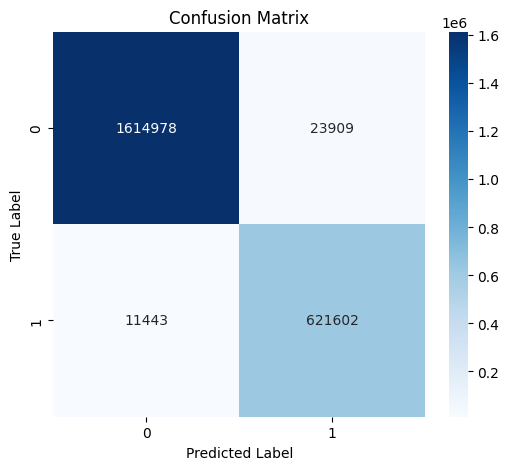

C:\Users\Aitthikit\AppData\Local\Temp\ipykernel_34256\1773306405.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  my_best_model.load_state_dict(torch.load(my_best_model_c

Misclassified samples with context:
Index: 32, True: 1, Pred: 0, Context: งทางกระบวนทัศน์และบริ, Input_Char: ท
Index: 53, True: 1, Pred: 0, Context: บทสังคมไทยThe Reforma, Input_Char: T
Index: 110, True: 1, Pred: 0, Context: tiveกระบวนทัศน์และวิธ, Input_Char: ท
Index: 228, True: 0, Pred: 1, Context: รด้านศึกษาศาสตร์ ครุศ, Input_Char: ศ
Index: 315, True: 0, Pred: 1, Context: หาวิทยาลัยฯ มาอย่างต่, Input_Char: ฯ
Index: 403, True: 1, Pred: 0, Context: าล) การจัดการศึกษาภาย, Input_Char: ก
Index: 423, True: 1, Pred: 0, Context: ยใต้กระบวนทัศน์และวิธ, Input_Char: ท
Index: 38, True: 1, Pred: 0, Context: วของการจัดการศึกษาเพื, Input_Char: ก
Index: 82, True: 0, Pred: 1, Context: ธรรมเสื่อมถอย ยาเสพติ, Input_Char: ถ
Index: 188, True: 1, Pred: 0, Context: ษาในกระบวนทัศน์แบบแยก, Input_Char: ท


n_iter,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,▇▂▇▂▂▅▂█▁▁▃▄▁▂▃▁▄▃█▂▁▄▁▃▁▂▁▁▁▃▁▁▆▂▂▂▃▄▅▁
val_accuracy,▁▅▆▆▇▇████
val_loss,█▄▃▃▂▂▁▁▁▁
n_iter,321519
train_loss,0.01253
val_accuracy,0.98368
val_loss,0.04865


(0.9844396751311218, 0.972350057408514, 0.9629611269211524, 0.9819238758698039, 0.046493951231241226)


In [41]:
result = evaluateCNN(test_loader, my_best_model)
my_best_model.load_state_dict(torch.load(my_best_model_checkpoint_path_feedforward_nn))
test_loader = DataLoader(Dataset(x_test_char, y_test, dtype = 'float'), batch_size = BATCHS_SIZE)
wrong_cases = show_wrong_predictions_CNN(my_best_model, test_loader, criterion, device="cuda", idx_to_char=CHARS_MAP)
wandb.finish() #ปิดการเชื่อมต่อกับ Weights & Biases
print(result)